# Predicting Codons using the trained Encoder model

In [1]:
import sys
import random
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import Tensor
import time
import math
import pickle as pkl
import matplotlib.pyplot as plt

sys.path.append('../scripts')
import ml_helper
import ml_evaluation
import Classifier as Classifier
import Baseline_classifiers as bc

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def to_pickle(obj, path):
    with open(path, 'wb') as file:
        pkl.dump(obj, file)
def from_pickle(path): 
    with open(path, 'rb') as file:
        return pkl.load(file)

### Data Preparation

In [4]:
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*',
               '_']

aminoacids_to_integer = dict((a, i) for i, a in enumerate(amino_acids))
integer_to_aminoacids = dict((i, a) for i, a in enumerate(amino_acids))

codons = ['TTT', 'TTC', 'TTA', 'TTG', 'TCT', 'TCC', 'TCA', 'TCG', 'TAT', 'TAC', 'TAA', 'TAG', 'TGT', 'TGC', 'TGA',
          'TGG', 'CTT', 'CTC', 'CTA', 'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT', 'CAC', 'CAA', 'CAG', 'CGT', 'CGC',
          'CGA', 'CGG', 'ATT', 'ATC', 'ATA', 'ATG', 'ACT', 'ACC', 'ACA', 'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT',
          'AGC', 'AGA', 'AGG', 'GTT', 'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA', 'GCG', 'GAT', 'GAC', 'GAA', 'GAG',
          'GGT', 'GGC', 'GGA', 'GGG', '___']

codons_to_integer = dict((c, i) for i, c in enumerate(codons))
integer_to_codons = dict((i, c) for i, c in enumerate(codons))

In [5]:
organism = "E.Coli"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

display(df.head())

,id,description,sequence,translation,seguid,codons
3847,lcl|U00096.3_cds_AAC76901.1_3848,lcl|U00096.3_cds_AAC76901.1_3848 [gene=tpiA] [...,"(A, T, G, C, G, A, C, A, T, C, C, T, T, T, A, ...","(M, R, H, P, L, V, M, G, N, W, K, L, N, G, S, ...",OTyeNS0ZMuPXyEyAv24l9hVsX4k,"[ATG, CGA, CAT, CCT, TTA, GTG, ATG, GGT, AAC, ..."
1699,lcl|U00096.3_cds_AAC74777.1_1700,lcl|U00096.3_cds_AAC74777.1_1700 [gene=rflP] [...,"(A, T, G, A, A, G, A, T, T, T, T, T, T, T, G, ...","(M, K, I, F, L, E, N, L, Y, H, S, D, C, Y, F, ...",jFRiqwuGUGqm4Xt6WEfCm/kY0KU,"[ATG, AAG, ATT, TTT, TTG, GAG, AAT, CTT, TAT, ..."
4084,lcl|U00096.3_cds_AAC77124.1_4085,lcl|U00096.3_cds_AAC77124.1_4085 [gene=nnr] [l...,"(A, T, G, A, C, G, G, A, C, C, A, T, A, C, A, ...","(M, T, D, H, T, M, K, K, N, P, V, S, I, P, H, ...",ThsVRsubR5A5+DqETGMbLiK2pg8,"[ATG, ACG, GAC, CAT, ACA, ATG, AAG, AAA, AAC, ..."
2577,lcl|U00096.3_cds_AAC75647.1_2578,lcl|U00096.3_cds_AAC75647.1_2578 [gene=pheL] [...,"(A, T, G, A, A, A, C, A, C, A, T, A, C, C, G, ...","(M, K, H, I, P, F, F, F, A, F, F, F, T, F, P)",L7VY605RFGwbOavs3L334aEqsgI,"[ATG, AAA, CAC, ATA, CCG, TTT, TTC, TTC, GCA, ..."
4122,lcl|U00096.3_cds_AAC77163.2_4123,lcl|U00096.3_cds_AAC77163.2_4123 [gene=ytfB] [...,"(A, T, G, C, C, C, G, G, G, C, G, C, T, T, T, ...","(M, P, G, R, F, E, L, K, P, T, L, E, K, V, W, ...",1L6ONX51WJS3OupxDqMUQ+HnFu8,"[ATG, CCC, GGG, CGC, TTT, GAA, CTA, AAA, CCA, ..."


In [6]:
min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)

In [7]:
len(df)

386

## Load trained model

In [8]:
SPEEDS_ADDED = False

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [10]:
class EncoderClassifier(nn.Module):
    def __init__(self, embed_dim, num_layers, num_heads, dropout=0.2, pos_enc=False):
        super(EncoderClassifier, self).__init__()

        emb_size = embed_dim
        if SPEEDS_ADDED:
            emb_size -= 1
        self.emb = nn.Embedding(len(amino_acids), emb_size, padding_idx=len(amino_acids)-1)
        self.pos_enc = pos_enc
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(embed_dim, len(codons))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        if SPEEDS_ADDED:
            x1 = self.emb(x[:, :, 0])
            x2 = x[:, :, 1].unsqueeze(-1)
            x = torch.cat((x1, x2), dim=-1)  # Concatenate along the feature dimension
        else:
            x = self.emb(x)

        if self.pos_enc:
            x = x.transpose(0, 1)
            x = self.pos_encoder(x)  # Add positional encoding
            x = x.transpose(0, 1)
        x = self.encoder(x)
        x = self.dropout(x)
        out = self.linear(x)
        return out

In [11]:
EMBED_DIM = 64
NUM_ENCODER_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.5

model = EncoderClassifier(
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    pos_enc=False
).to(device)
model = ml_helper.load_model('encoder_64em_2l_4h_05dr', organism, device=device)

Model loaded: 20240603143927_encoder_64em_2l_4h_05dr_21ep.pt


## Prepare data for max_length cutting and putting together again

In [12]:
def cut_sequence(aa_sequence, max_length):
    aa_sequences = []
    bit_map = "" # 1 if sequence is cut, 0 if not
    if aa_sequence.shape[0] <= max_length:
        aa_sequences = [aa_sequence]
        bit_map = "0"
    elif aa_sequence.shape[0] > max_length:
        aa_splits = ml_helper._split_tensor(aa_sequence, max_length)
        aa_sequences = aa_splits
        bit_map = "1" * (len(aa_splits) - 1) + "0"
    return aa_sequences, bit_map

In [13]:
def rebuild_sequences(sequences, cut_bit_map):
    new_sequences = []
    new_sequence = None
    for i, sequence in enumerate(sequences):
        if new_sequence is None:
            new_sequence = sequence
        elif new_sequence is not None:
            if type(new_sequence) == torch.Tensor:
                new_sequence = torch.cat((new_sequence, sequence))
            elif type(new_sequence) == list:
                new_sequence += sequence

        if cut_bit_map[i] == "0":
            new_sequences.append(new_sequence)
            new_sequence = None
    return new_sequences

In [14]:
def remove_padding(sequence, padding_value):
    return sequence[sequence != padding_value]

In [15]:
padding_pos = 'right'
def prepare_aa_sequence(aa_sequence):
    max_length = 500
    non_cut_aa_sequence = ml_helper.aa_to_int_tensor(aa_sequence, device)
    aa_sequences, bit_map = cut_sequence(non_cut_aa_sequence, max_length)
    for i, aa_sequence in enumerate(aa_sequences):
        aa_sequences[i] = ml_helper.pad_tensor(aa_sequence, max_length, aminoacids_to_integer['_'], padding_pos)
        if SPEEDS_ADDED:
            aa_sequences[i] = ml_helper.add_speed_dimension(aa_sequences[i], device)
    return aa_sequences, bit_map, non_cut_aa_sequence

In [16]:
# Prepare data (pad, convert to tensor)
prepared_amino_seq = []
cut_bit_map = ""
non_cut_aa_sequences = []
i = 0
for seq in df['translation']:
    aa_sequences, bit_map, non_cut_aa_sequence = prepare_aa_sequence(seq)
    prepared_amino_seq += aa_sequences
    cut_bit_map += bit_map
    non_cut_aa_sequences.append(non_cut_aa_sequence)
# create data_loader for batched throughput
batch_size = 32
data_loader = DataLoader(prepared_amino_seq, batch_size=batch_size)

In [17]:
if SPEEDS_ADDED:
    for i, aa_sequence in enumerate(prepared_amino_seq):
        prepared_amino_seq[i] = aa_sequence[:, 0].int()

In [18]:
re_sequences = rebuild_sequences(prepared_amino_seq, cut_bit_map)

In [19]:
for i, rebuild_sequence in enumerate(re_sequences):
    re_sequences[i] = remove_padding(rebuild_sequence, aminoacids_to_integer["_"])

In [20]:
def are_lists_equal(list1, list2):
    if len(list1) != len(list2):
        return False

    for tensor1, tensor2 in zip(list1, list2):
        if tensor1.shape[0] != tensor2.shape[0]:
            return False
        if not torch.allclose(tensor1, tensor2):
            return False

    return True

In [21]:
are_lists_equal(non_cut_aa_sequences, re_sequences)

True

## Testing the codon prediction

In [22]:
def count_correct_predictions(predictions, labels):
    predictions = np.argmax(predictions, axis=1)

    # Find indices where labels are not equal to the padding value
    non_padding_indices = labels != codons_to_integer['___']

    # Filter out predictions and labels where the label is not padding
    filtered_predictions = predictions[non_padding_indices]
    filtered_labels = labels[non_padding_indices]

    codon_num = filtered_labels.shape[0]
    correct_codons = (filtered_predictions == filtered_labels).sum().item()
    return codon_num, correct_codons

In [23]:
def predict_codons(model, aa_sequence_list):
    # Prepare data (pad, convert to tensor)
    prepared_amino_seq = []
    cut_bit_map = ""
    for seq in aa_sequence_list:
        aa_sequences, bit_map, _ = prepare_aa_sequence(seq)
        prepared_amino_seq += aa_sequences
        cut_bit_map += bit_map

    # create data_loader for batched throughput
    batch_size = 32
    data_loader = DataLoader(prepared_amino_seq, batch_size=batch_size)

    model.eval()
    codon_predictions = []
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch)  # (batch_size, seq_len, num_classes)

            for batch_i in range(output.shape[0]):
                predicted_codons = []
                for seq_i in range(output.shape[1]):
                    if SPEEDS_ADDED:
                        aa_num = batch[batch_i][seq_i][0].item()
                    else:
                        aa_num = batch[batch_i][seq_i].item()
                    if aa_num == aminoacids_to_integer['_']:
                        continue
                    codon_idx = torch.argmax(output[batch_i][seq_i]).item()
                    codon = integer_to_codons[codon_idx]
                    predicted_codons.append(codon)
                codon_predictions.append(predicted_codons)
    codon_predictions = rebuild_sequences(codon_predictions, cut_bit_map)
    assert len(aa_sequence_list) == len(codon_predictions)
    return codon_predictions

In [24]:
amino_seq = df['translation'].head(40)
batched_predictions = predict_codons(model, amino_seq)

In [25]:
len(batched_predictions[0])

255

## Building the classifier

In [26]:
amino_acids_to_codons = {
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    'N': ['AAT', 'AAC'],
    'D': ['GAT', 'GAC'],
    'C': ['TGT', 'TGC'],
    'Q': ['CAA', 'CAG'],
    'E': ['GAA', 'GAG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
    'H': ['CAT', 'CAC'],
    'I': ['ATT', 'ATC', 'ATA'],
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    'K': ['AAA', 'AAG'],
    'M': ['ATG'],
    'F': ['TTT', 'TTC'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'W': ['TGG'],
    'Y': ['TAT', 'TAC'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    '*': ['TAA', 'TAG', 'TGA'],
    '_': ['___']
}

In [27]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
def check_and_replace_codons(aa_sequences, codon_predictions_list):
    total_codons = 0
    not_possible_codons = 0
    used_max_bias = 0
    for i, aa_seq in enumerate(aa_sequences):
        codon_predictions = codon_predictions_list[i]
        for j, aa in enumerate(aa_seq):
            total_codons += 1
            codon_pred = codon_predictions[j]
            max_bias_pred = max_weighted_bc._predict_codon(aa)
            if codon_pred not in amino_acids_to_codons[aa]:
                not_possible_codons += 1
                
                codon_predictions_list[i][j] = max_bias_pred
            else:
                if codon_pred == max_bias_pred:
                    used_max_bias += 1
    max_bias_ratio = used_max_bias / total_codons
    print(f"Model used max bias codon for {max_bias_ratio*100:.2f}% of possible codon predictions")
    not_possible_ratio = not_possible_codons / total_codons
    print(f"Replaced {not_possible_ratio*100:.2f}% of codons")
    return codon_predictions_list

In [28]:
class Encoder_Classifier(Classifier.Classifier):
    def __init__(self, trained_model, seed=42):
        self.model = trained_model
        super().__init__(seed)


    def predict_codons(self, aa_sequences, replace=False):
        predictions_list = predict_codons(self.model, aa_sequences)
        if replace:
            predictions_list = check_and_replace_codons(aa_sequences, predictions_list)
        predictions_matrix = self.pad_and_convert_seq(predictions_list)
        return predictions_matrix

## Results Hyperparameter Tuning

In [29]:
def eval_parameter_model(embed_dim, num_encoder_layers, num_heads, dropout, pos_enc):
    start_time = time.time()

    model = EncoderClassifier(
        embed_dim=embed_dim,
        num_layers=num_encoder_layers,
        num_heads=num_heads
    ).to(device)
    try:
        model = ml_helper.load_model( f'encoder_{embed_dim}em_{num_encoder_layers}l_{num_heads}h{"_posenc" if pos_enc else ""}_{str(dropout).replace(".","")}dr', organism, device=device)
    except:
        print("Not found:")
        print(f'encoder_{embed_dim}em_{num_encoder_layers}l_{num_heads}h{"_posenc" if pos_enc else ""}_{str(dropout).replace(".","")}dr')
        return

    encoder_classifier = Encoder_Classifier(model)
    amino_seq = df['translation']
    true_codons = df['codons']
    pred_codons_replaced = encoder_classifier.predict_codons(amino_seq, replace=True)

    accuracy = round(encoder_classifier.calc_accuracy(true_codons, pred_codons_replaced), 4)
    print(f"Accuracy: {accuracy} - Organism: {organism}, Encoder Model - Parameters: {embed_dim} embedding dim, {num_encoder_layers} layers, {num_heads} heads")
    print(f"Took {round(time.time() - start_time, 2)} seconds")
    print("")
    return accuracy

In [30]:
def eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, dropouts, pos_enc):
    for EMBED_DIM in embed_dims:
        for NUM_ENCODER_LAYERS in num_encoder_layers:
            for NUM_HEADS in num_heads:
                for DROPOUT in dropouts:
                    for POS_ENC in pos_enc:
                        model_name = f'encoder_{EMBED_DIM}em_{NUM_ENCODER_LAYERS}l_{NUM_HEADS}h{"_posenc" if POS_ENC else ""}_{str(DROPOUT).replace(".","")}dr'
                        if model_name not in accuracies:
                            accuracy = eval_parameter_model(EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUT, POS_ENC)
                            if accuracy is not None:
                                accuracies[model_name] = accuracy
                            else:
                                accuracies[model_name] = 0
    print("------")
    print(accuracies)
    print("------")
    print(max(accuracies.items(), key=lambda item: item[1]))
    return accuracies

### E.Coli

In [31]:
organism = "E.Coli"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

386

In [32]:
accuracies = {}

#### Dropout

In [37]:
EMBED_DIM = [256]
NUM_ENCODER_LAYERS = [4]
NUM_HEADS = [4]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, dropouts, POS_ENC)

Model loaded: 20240603142405_encoder_256em_4l_4h_01dr_16ep.pt
Model used max bias codon for 82.49% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.521 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads
Took 4.76 seconds

Model loaded: 20240603142505_encoder_256em_4l_4h_02dr_16ep.pt
Model used max bias codon for 82.47% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5205 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads
Took 4.72 seconds

Model loaded: 20240603142604_encoder_256em_4l_4h_03dr_16ep.pt
Model used max bias codon for 82.44% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5207 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads
Took 4.71 seconds

Model loaded: 20240603142704_encoder_256em_4l_4h_04dr_16ep.pt
Model used max bias codon for 82.02% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5212 - Org

#### Embedding Dimension

In [38]:
embed_dims = [16, 32, 64, 128, 256, 512]
NUM_ENCODER_LAYERS = [4]
NUM_HEADS = [4]
DROPOUTS = [0.5]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, embed_dims, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUTS, POS_ENC)

Model loaded: 20240603143100_encoder_16em_4l_4h_05dr_18ep.pt
Model used max bias codon for 94.67% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5196 - Organism: E.Coli, Encoder Model - Parameters: 16 embedding dim, 4 layers, 4 heads
Took 4.73 seconds

Model loaded: 20240603143205_encoder_32em_4l_4h_05dr_31ep.pt
Model used max bias codon for 97.43% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5228 - Organism: E.Coli, Encoder Model - Parameters: 32 embedding dim, 4 layers, 4 heads
Took 4.67 seconds

Model loaded: 20240603143249_encoder_64em_4l_4h_05dr_20ep.pt
Model used max bias codon for 94.01% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5262 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 4.74 seconds

Model loaded: 20240603143309_encoder_128em_4l_4h_05dr_8ep.pt
Model used max bias codon for 95.48% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5227 - Organism:

#### Number Encoder Layers and Heads

In [39]:
EMBED_DIM = [64]
num_encoder_layers = [1, 2, 4, 8]
num_heads = [1, 2, 4, 8]
DROPOUTS = [0.5]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, EMBED_DIM, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

/home/mkuehn/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model loaded: 20240603143811_encoder_64em_1l_1h_05dr_8ep.pt
Model used max bias codon for 99.54% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5186 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 1 layers, 1 heads
Took 4.59 seconds

Model loaded: 20240603143816_encoder_64em_1l_2h_05dr_8ep.pt
Model used max bias codon for 99.36% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.519 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 1 layers, 2 heads
Took 4.6 seconds

Model loaded: 20240603143821_encoder_64em_1l_4h_05dr_8ep.pt
Model used max bias codon for 99.33% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5198 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 1 layers, 4 heads
Took 4.6 seconds

Model loaded: 20240603143832_encoder_64em_1l_8h_05dr_15ep.pt
Model used max bias codon for 94.08% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5226 - Organism: E.Col

#### Positional Encoding

In [47]:
EMBED_DIM = [64]
NUM_ENCODER_LAYERS = [2]
NUM_HEADS = [4]
DROPOUTS = [0.5]
pos_enc = [True, False]
accuracies = eval_hyperparameter_training(accuracies, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUTS, pos_enc)

Model loaded: 20240603145400_encoder_64em_2l_4h_05dr_posenc_13ep.pt
Model used max bias codon for 97.97% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5194 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 2 layers, 4 heads
Took 4.68 seconds

------
{'encoder_256em_4l_4h_01dr': 0.521, 'encoder_256em_4l_4h_02dr': 0.5205, 'encoder_256em_4l_4h_03dr': 0.5207, 'encoder_256em_4l_4h_04dr': 0.5212, 'encoder_256em_4l_4h_05dr': 0.5215, 'encoder_16em_4l_4h_05dr': 0.5196, 'encoder_32em_4l_4h_05dr': 0.5228, 'encoder_64em_4l_4h_05dr': 0.5262, 'encoder_128em_4l_4h_05dr': 0.5227, 'encoder_512em_4l_4h_05dr': 0.5099, 'encoder_64em_1l_1h_05dr': 0.5186, 'encoder_64em_1l_2h_05dr': 0.519, 'encoder_64em_1l_4h_05dr': 0.5198, 'encoder_64em_1l_8h_05dr': 0.5226, 'encoder_64em_2l_1h_05dr': 0.5263, 'encoder_64em_2l_2h_05dr': 0.5241, 'encoder_64em_2l_4h_05dr': 0.5264, 'encoder_64em_2l_8h_05dr': 0.5258, 'encoder_64em_4l_1h_05dr': 0.5258, 'encoder_64em_4l_2h_05dr': 0.5253, 'encode

#### Save E.Coli accuracies

In [48]:
to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [49]:
accuracies = from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [50]:
accuracies

{'encoder_256em_4l_4h_01dr': 0.521,
 'encoder_256em_4l_4h_02dr': 0.5205,
 'encoder_256em_4l_4h_03dr': 0.5207,
 'encoder_256em_4l_4h_04dr': 0.5212,
 'encoder_256em_4l_4h_05dr': 0.5215,
 'encoder_16em_4l_4h_05dr': 0.5196,
 'encoder_32em_4l_4h_05dr': 0.5228,
 'encoder_64em_4l_4h_05dr': 0.5262,
 'encoder_128em_4l_4h_05dr': 0.5227,
 'encoder_512em_4l_4h_05dr': 0.5099,
 'encoder_64em_1l_1h_05dr': 0.5186,
 'encoder_64em_1l_2h_05dr': 0.519,
 'encoder_64em_1l_4h_05dr': 0.5198,
 'encoder_64em_1l_8h_05dr': 0.5226,
 'encoder_64em_2l_1h_05dr': 0.5263,
 'encoder_64em_2l_2h_05dr': 0.5241,
 'encoder_64em_2l_4h_05dr': 0.5264,
 'encoder_64em_2l_8h_05dr': 0.5258,
 'encoder_64em_4l_1h_05dr': 0.5258,
 'encoder_64em_4l_2h_05dr': 0.5253,
 'encoder_64em_4l_8h_05dr': 0.5251,
 'encoder_64em_8l_1h_05dr': 0.5252,
 'encoder_64em_8l_2h_05dr': 0.5235,
 'encoder_64em_8l_4h_05dr': 0.523,
 'encoder_64em_8l_8h_05dr': 0.5253,
 'encoder_64em_2l_4h_05dr_posenc': 0.5194}

--> Best suited parameters: encoder_64em_2l_4h_05dr - Accuracy: 0.5264

#### Baseline Classifier

In [51]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
amino_seq = df['translation'].apply(lambda seq: list(seq))
true_codons = df['codons']
pred_codons_bc = max_weighted_bc.predict_codons(amino_seq)
accuracy = max_weighted_bc.calc_accuracy(true_codons, pred_codons_bc)
accuracy = round(accuracy, 4)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus E.Coli - Accuracy: 0.5186


### Drosophila.Melanogaster

In [54]:
organism = "Drosophila.Melanogaster"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

2168

In [55]:
accuracies = {}

In [56]:
embed_dims = [64, 128]
num_encoder_layers = [2, 4]
num_heads = [2, 4]
DROPOUTS = [0.2, 0.5]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240603150541_encoder_64em_2l_2h_02dr_10ep.pt
Model used max bias codon for 56.96% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4986 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 2 layers, 2 heads
Took 56.4 seconds

Model loaded: 20240603150712_encoder_64em_2l_2h_05dr_10ep.pt
Model used max bias codon for 57.40% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4981 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 2 layers, 2 heads
Took 56.68 seconds

Model loaded: 20240603150858_encoder_64em_2l_4h_02dr_10ep.pt
Model used max bias codon for 56.39% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4986 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 2 layers, 4 heads
Took 56.66 seconds

Model loaded: 20240603151045_encoder_64em_2l_4h_05dr_10ep.pt
Model used max bias codon for 56.84% of possible codon predictions


In [69]:
# Test best model, trained for longer
embed_dims = [64]
num_encoder_layers = [4]
num_heads = [4]
DROPOUTS = [0.2]
POS_ENC = [False, True]
accuracies = eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240603163741_encoder_64em_4l_4h_posenc_02dr_50ep.pt
Model used max bias codon for 78.75% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5101 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 57.55 seconds

------
{'encoder_64em_2l_2h_02dr': 0.4986, 'encoder_64em_2l_2h_05dr': 0.4981, 'encoder_64em_2l_4h_02dr': 0.4986, 'encoder_64em_2l_4h_05dr': 0.4982, 'encoder_64em_4l_2h_02dr': 0.4982, 'encoder_64em_4l_2h_05dr': 0.4982, 'encoder_64em_4l_4h_02dr': 0.4988, 'encoder_64em_4l_4h_05dr': 0.4982, 'encoder_128em_2l_2h_02dr': 0.4983, 'encoder_128em_2l_2h_05dr': 0.4986, 'encoder_128em_2l_4h_02dr': 0.4987, 'encoder_128em_2l_4h_05dr': 0.4983, 'encoder_128em_4l_2h_02dr': 0.4981, 'encoder_128em_4l_2h_05dr': 0.4979, 'encoder_128em_4l_4h_02dr': 0.4982, 'encoder_128em_4l_4h_05dr': 0.4978, 'encoder_64em_4l_4h_posenc_02dr': 0.5101}
------
('encoder_64em_4l_4h_posenc_02dr', 0.5101)


#### Save Drosophila.Melanogaster accuracies

In [70]:
to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [71]:
accuracies = from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [74]:
accuracies

{'encoder_64em_2l_2h_02dr': 0.4986,
 'encoder_64em_2l_2h_05dr': 0.4981,
 'encoder_64em_2l_4h_02dr': 0.4986,
 'encoder_64em_2l_4h_05dr': 0.4982,
 'encoder_64em_4l_2h_02dr': 0.4982,
 'encoder_64em_4l_2h_05dr': 0.4982,
 'encoder_64em_4l_4h_02dr': 0.4988,
 'encoder_64em_4l_4h_05dr': 0.4982,
 'encoder_128em_2l_2h_02dr': 0.4983,
 'encoder_128em_2l_2h_05dr': 0.4986,
 'encoder_128em_2l_4h_02dr': 0.4987,
 'encoder_128em_2l_4h_05dr': 0.4983,
 'encoder_128em_4l_2h_02dr': 0.4981,
 'encoder_128em_4l_2h_05dr': 0.4979,
 'encoder_128em_4l_4h_02dr': 0.4982,
 'encoder_128em_4l_4h_05dr': 0.4978,
 'encoder_64em_4l_4h_posenc_02dr': 0.5101}

--> Best suited parameters: encoder_64em_4l_4h_posenc_02dr - Accuracy: 0.5101

#### Baseline Classifier

In [73]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
amino_seq = df['translation'].apply(lambda seq: list(seq))
true_codons = df['codons']
pred_codons_bc = max_weighted_bc.predict_codons(amino_seq)
accuracy = max_weighted_bc.calc_accuracy(true_codons, pred_codons_bc)
accuracy = round(accuracy, 4)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus Drosophila.Melanogaster - Accuracy: 0.4917


### Homo.Sapiens

In [34]:
organism = "Homo.Sapiens"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)
df = ml_helper.remove_x_rows(df)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

9139

In [76]:
accuracies = {}

In [77]:
embed_dims = [64]
num_encoder_layers = [4]
num_heads = [4]
DROPOUTS = [0.2]
POS_ENC = [False, True]
accuracies = eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240603182243_encoder_64em_4l_4h_02dr_55ep.pt
Model used max bias codon for 54.50% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5106 - Organism: Homo.Sapiens, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 282.53 seconds

Model loaded: 20240603201950_encoder_64em_4l_4h_posenc_02dr_80ep.pt
Model used max bias codon for 50.25% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5232 - Organism: Homo.Sapiens, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 284.51 seconds

------
{'encoder_64em_4l_4h_02dr': 0.5106, 'encoder_64em_4l_4h_posenc_02dr': 0.5232}
------
('encoder_64em_4l_4h_posenc_02dr', 0.5232)


#### Save Homo.Sapiens accuracies

In [78]:
to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [79]:
accuracies = from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [80]:
accuracies

{'encoder_64em_4l_4h_02dr': 0.5106, 'encoder_64em_4l_4h_posenc_02dr': 0.5232}

--> Best suited parameters: encoder_64em_4l_4h_posenc_02dr - Accuracy: 0.5232

#### Baseline Classifier

In [81]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
amino_seq = df['translation'].apply(lambda seq: list(seq))
true_codons = df['codons']
pred_codons_bc = max_weighted_bc.predict_codons(amino_seq)
accuracy = max_weighted_bc.calc_accuracy(true_codons, pred_codons_bc)
accuracy = round(accuracy, 4)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus Homo.Sapiens - Accuracy: 0.438


# Visualisation

## E.Coli

In [31]:
organism = "E.Coli"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

386

In [32]:
EMBED_DIM = 64
NUM_ENCODER_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.5
POS_ENC = False

model = EncoderClassifier(
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
).to(device)
model = ml_helper.load_model( f'encoder_{EMBED_DIM}em_{NUM_ENCODER_LAYERS}l_{NUM_HEADS}h{"_posenc" if POS_ENC else ""}_{str(DROPOUT).replace(".","")}dr', organism, device)

encoder_classifier = Encoder_Classifier(model)
amino_seq = df['translation']
true_codons = df['codons']
pred_codons_replaced = encoder_classifier.predict_codons(amino_seq, replace=True)

accuracy = round(encoder_classifier.calc_accuracy(true_codons, pred_codons_replaced), 4)
print(f"Accuracy: {accuracy}")

Model loaded: 20240603143927_encoder_64em_2l_4h_05dr_21ep.pt
Model used max bias codon for 93.21% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5264


In [33]:
# Remove Padding
predictions = []
for codon_seq in pred_codons_replaced:
    predictions.append([codon for codon in codon_seq if codon != ''])

In [34]:
predicted, labels = ml_evaluation.flatten_for_plotting(predictions, true_codons, filter_pads=False)

In [35]:
# Translate to integers
predicted_int = []
for codon in predicted:
    predicted_int.append(ml_helper.codons_to_integer[codon])

labels_int = []
for codon in labels:
    labels_int.append(ml_helper.codons_to_integer[codon])

In [36]:
# Calculate Accuracy again to see if something changed
predicted_int_np = np.array(predicted_int)
labels_int_np = np.array(labels_int)
accuracy = np.sum(predicted_int_np == labels_int_np) / labels_int_np.size
accuracy

0.5263641963328918

In [37]:
ml_evaluation.get_unique_pred_classes(predicted, labels)

predicted different classes:  39 out of: 61
predicted following classes:  {'GTT', 'CGC', 'TGC', 'GGT', 'CGT', 'CTG', 'AGA', 'CAG', 'ATC', 'CAA', 'CCG', 'GCT', 'TCT', 'TGT', 'GAT', 'TAT', 'TTA', 'TTT', 'AAT', 'ACC', 'CAT', 'ATT', 'TCA', 'GCG', 'CCA', 'AAA', 'CAC', 'GCA', 'ATG', 'GAA', 'GAC', 'GTG', 'GGC', 'ACA', 'AGC', 'AAC', 'TGG', 'TAC', 'TTC'}


({'AAA',
  'AAC',
  'AAT',
  'ACA',
  'ACC',
  'AGA',
  'AGC',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCG',
  'CGC',
  'CGT',
  'CTG',
  'GAA',
  'GAC',
  'GAT',
  'GCA',
  'GCG',
  'GCT',
  'GGC',
  'GGT',
  'GTG',
  'GTT',
  'TAC',
  'TAT',
  'TCA',
  'TCT',
  'TGC',
  'TGG',
  'TGT',
  'TTA',
  'TTC',
  'TTT'},
 {'AAA',
  'AAC',
  'AAG',
  'AAT',
  'ACA',
  'ACC',
  'ACG',
  'ACT',
  'AGA',
  'AGC',
  'AGG',
  'AGT',
  'ATA',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCC',
  'CCG',
  'CCT',
  'CGA',
  'CGC',
  'CGG',
  'CGT',
  'CTA',
  'CTC',
  'CTG',
  'CTT',
  'GAA',
  'GAC',
  'GAG',
  'GAT',
  'GCA',
  'GCC',
  'GCG',
  'GCT',
  'GGA',
  'GGC',
  'GGG',
  'GGT',
  'GTA',
  'GTC',
  'GTG',
  'GTT',
  'TAC',
  'TAT',
  'TCA',
  'TCC',
  'TCG',
  'TCT',
  'TGC',
  'TGG',
  'TGT',
  'TTA',
  'TTC',
  'TTG',
  'TTT'})

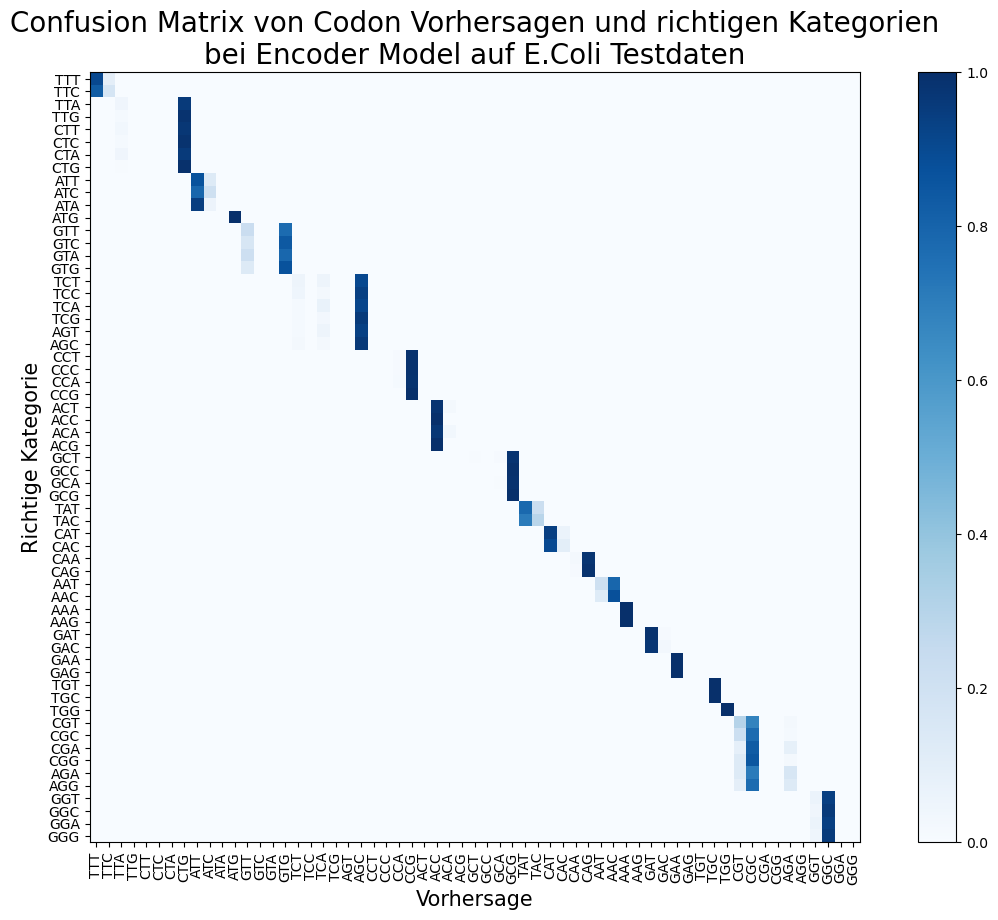

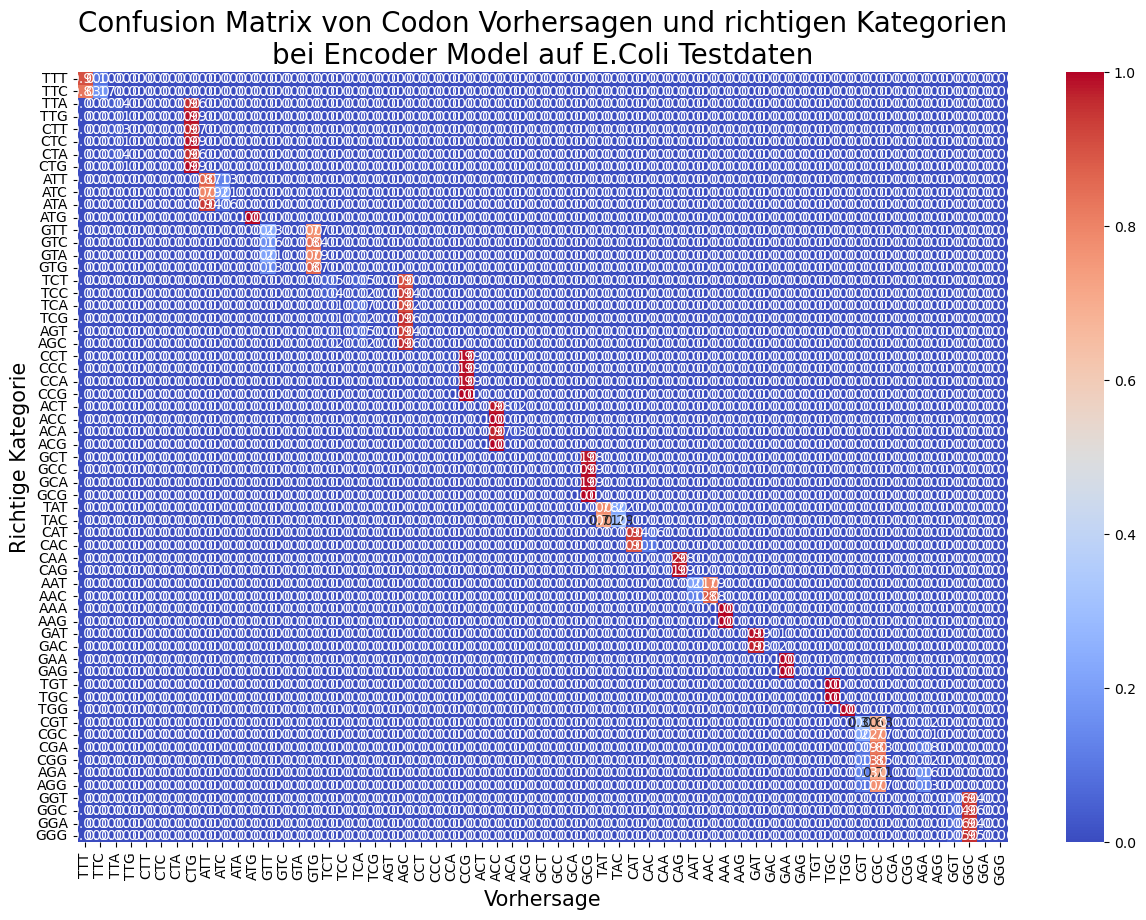

In [41]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien\nbei Encoder Model auf E.Coli Testdaten'

plt = ml_evaluation.plot_confusion_matrix(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()
plt = ml_evaluation.plot_confusion_matrix_sns(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()

In [38]:
predicted_aa =  ml_evaluation.translate_codons(predicted)
labels_aa =  ml_evaluation.translate_codons(labels)

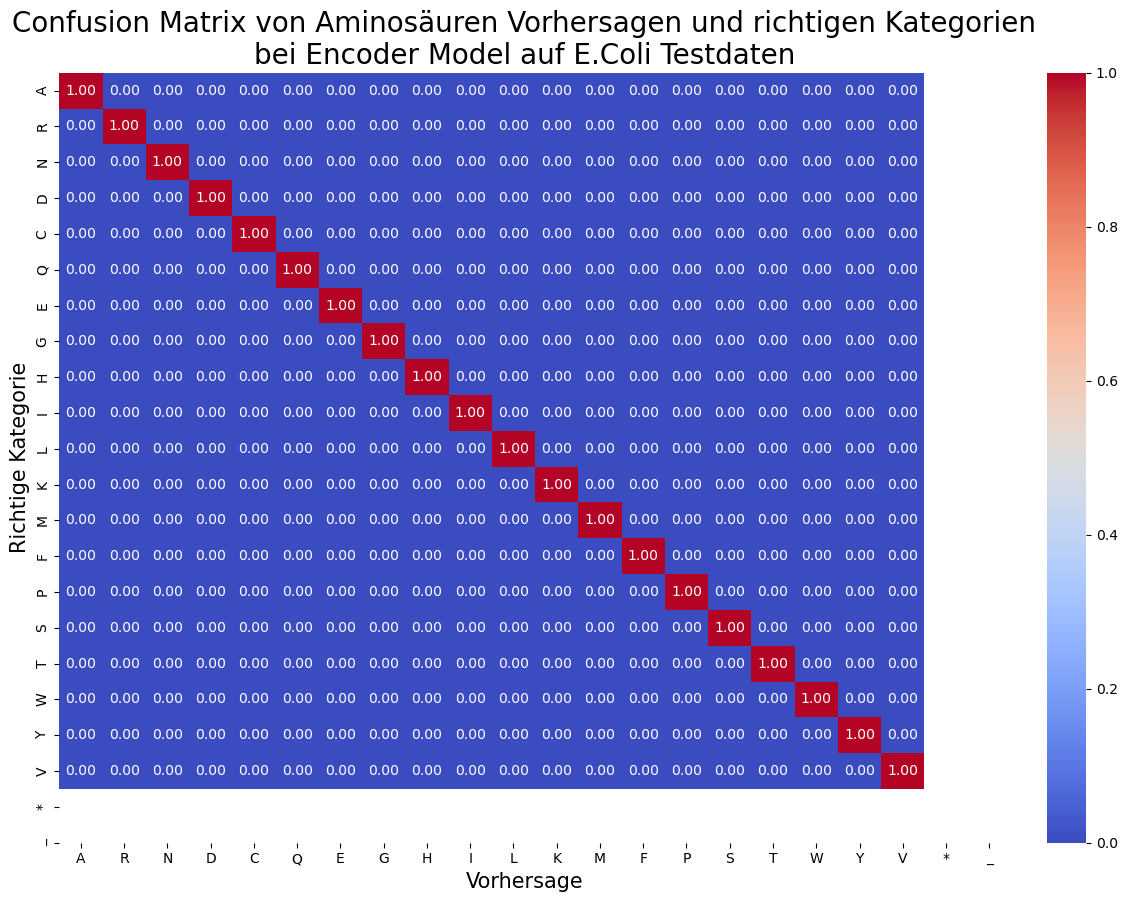

In [43]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, ml_helper.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien\nbei Encoder Model auf E.Coli Testdaten')
plt.show()

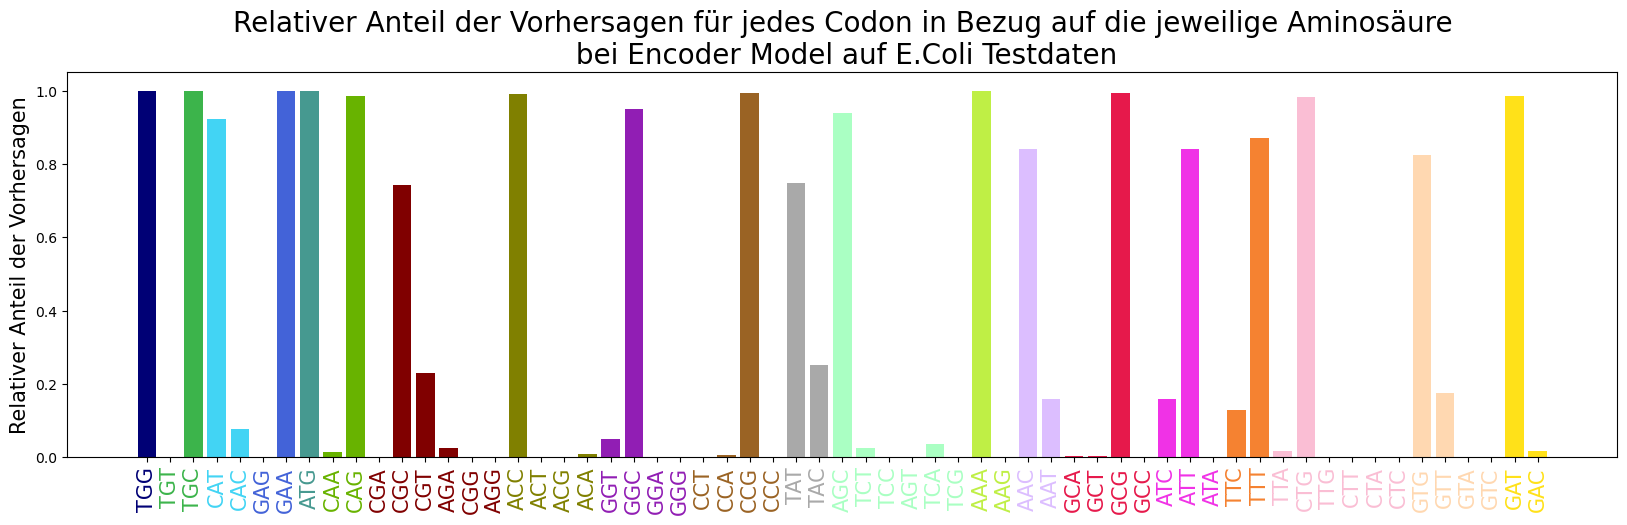

In [44]:
codon_counted_predicted = ml_evaluation.codon_count(predicted_int, labels)

plt = ml_evaluation.plot_relative_codon_count(codon_counted_predicted, predicted_int, 'Relativer Anteil der Vorhersagen für jedes Codon in Bezug auf die jeweilige Aminosäure\n bei Encoder Model auf E.Coli Testdaten')

{'ATG': 3365, 'CGA': 0, 'CAT': 1472, 'CCT': 0, 'TTA': 69, 'GTG': 2670, 'GGT': 191, 'AAC': 2384, 'TGG': 1761, 'AAA': 4148, 'CTG': 6363, 'GGC': 3370, 'AGC': 1819, 'CGC': 1900, 'CAC': 113, 'GTT': 514, 'GAG': 0, 'TCT': 54, 'CGT': 783, 'GCA': 18, 'GCT': 8, 'TGT': 0, 'GCG': 3956, 'ATC': 626, 'CCA': 14, 'CCG': 2772, 'GAA': 4742, 'TAT': 1468, 'GAT': 3794, 'AAG': 0, 'CAA': 38, 'GAC': 56, 'TCC': 0, 'TTC': 350, 'ACC': 2864, 'CAG': 3462, 'TAC': 421, 'ACT': 0, 'TGC': 747, 'AAT': 431, 'GTA': 0, 'ATT': 3155, 'TTT': 2367, 'GCC': 0, 'TTG': 0, 'CTT': 0, 'ATA': 0, 'AGA': 35, 'GTC': 0, 'AGT': 0, 'ACG': 0, 'CGG': 0, 'TCA': 58, 'CTA': 0, 'CTC': 0, 'ACA': 23, 'AGG': 0, 'GGA': 0, 'TCG': 0, 'CCC': 0, 'GGG': 0}


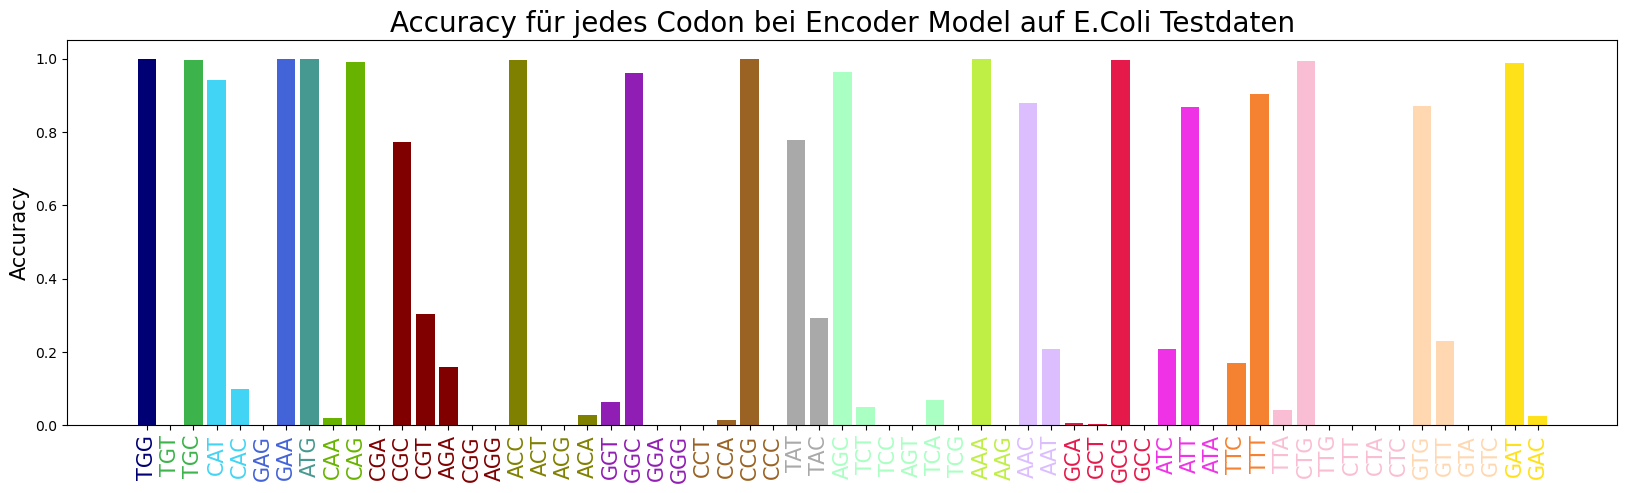

In [45]:
plt = ml_evaluation.plot_codon_acc(labels_int, predicted_int, 'Accuracy für jedes Codon bei Encoder Model auf E.Coli Testdaten')

In [40]:
usage_biases_codons = {}
codon_to_aa = ml_evaluation.dict_aa_codon()
for codon in labels:
    aa = codon_to_aa[codon]
    usage_biases_codons[codon] = usage_biases[aa][codon]

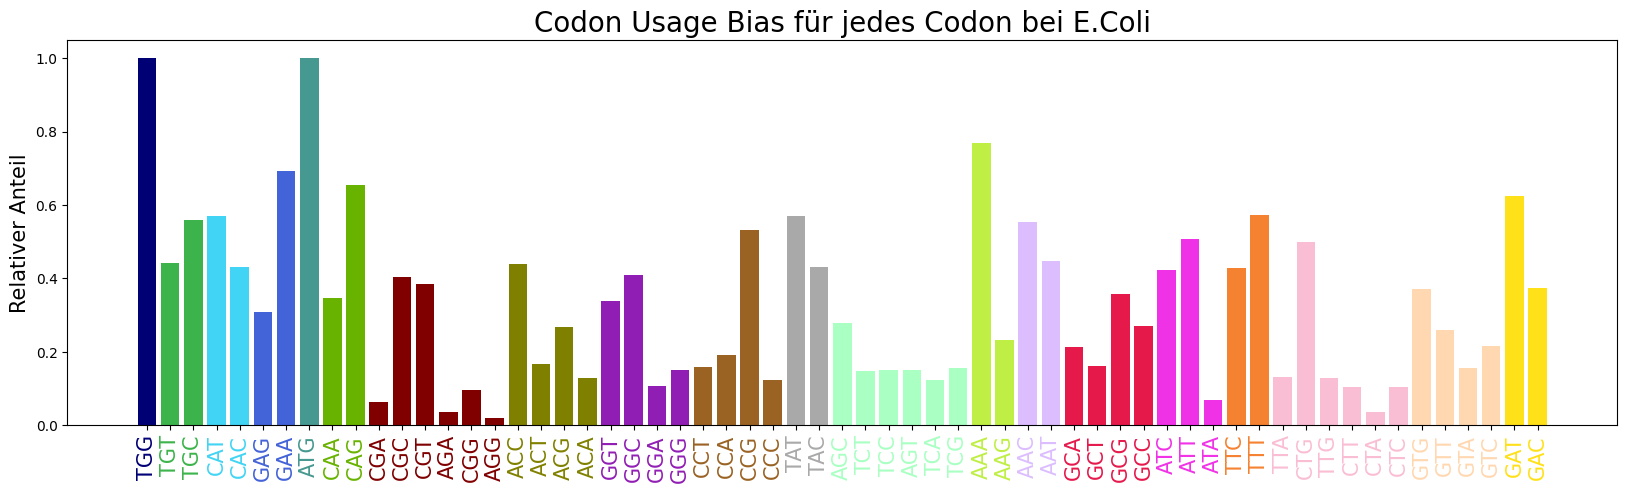

In [42]:
_, _ = ml_evaluation.plot_cub(usage_biases_codons, "Codon Usage Bias für jedes Codon bei E.Coli")

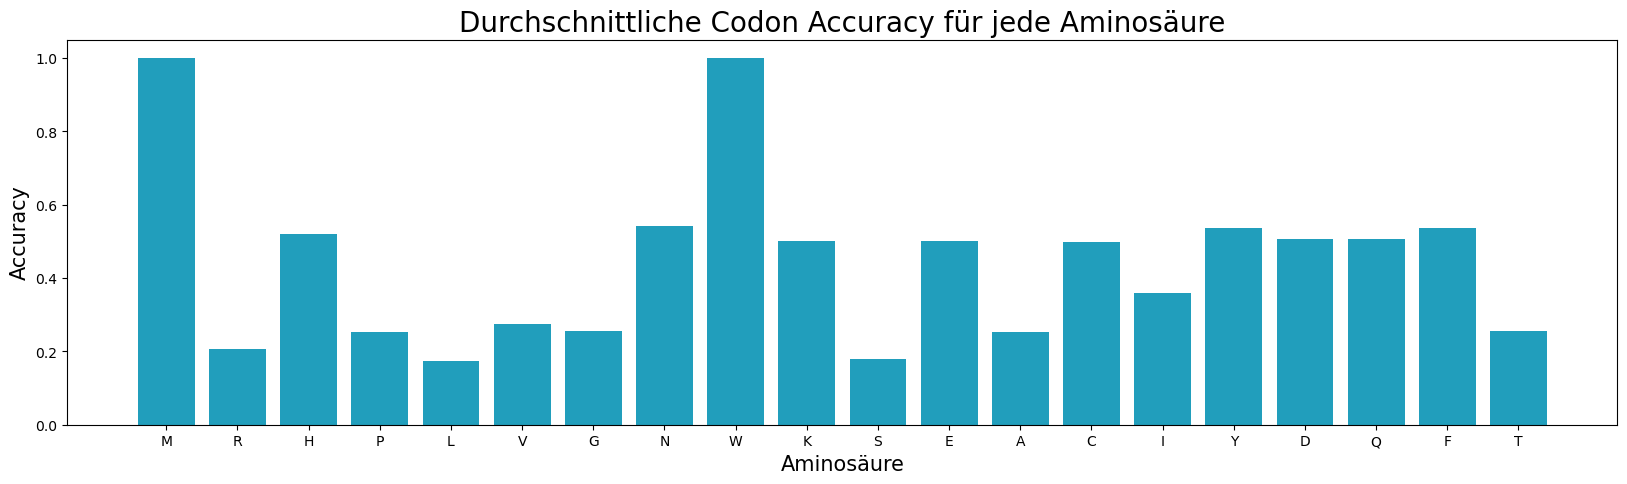

In [48]:
ml_evaluation.plot_avg_aa_acc(labels_int, predicted_int).show()

#### Comparison Max CUB

In [44]:
pn_dict = ml_evaluation.create_pn_dict(predicted, labels, organism)

In [45]:
cub_test_data = {}

for codon in pn_dict:
    aa = ml_helper.codon_to_amino_acid[codon]
    aa_codons = ml_helper.amino_acids_to_codons.get(aa, [])
    aa_sum = sum(pn_dict[c]['num'] for c in aa_codons)
    cub_test_data[codon] = pn_dict[codon]['num'] / aa_sum

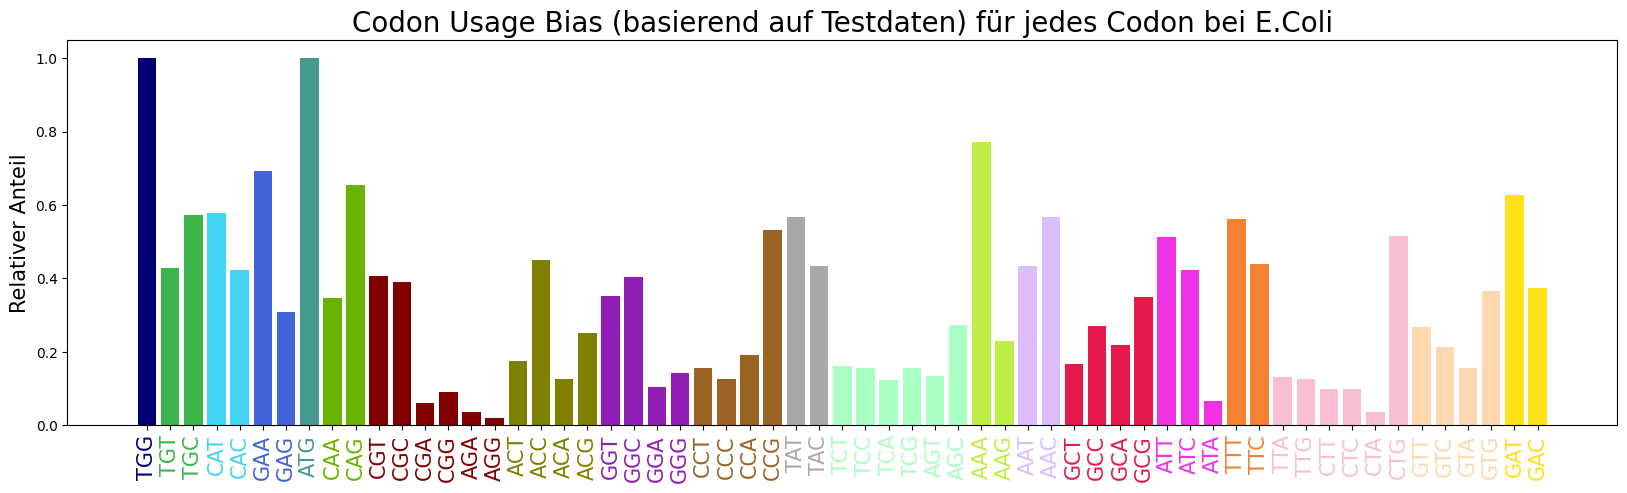

In [46]:
_, keys = ml_evaluation.plot_cub(cub_test_data, "Codon Usage Bias (basierend auf Testdaten) für jedes Codon bei E.Coli")

In [47]:
pn_dict = ml_evaluation.create_pn_dict(predicted, labels, organism, sorting=keys)

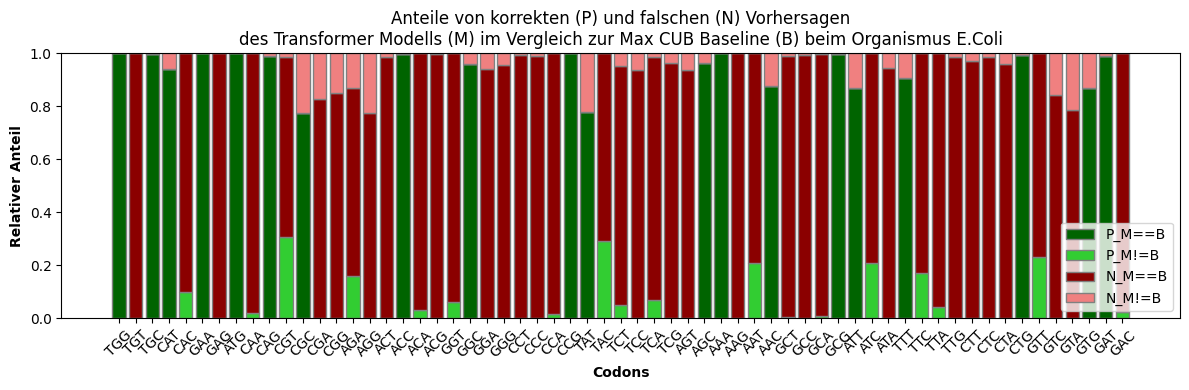

In [48]:
ml_evaluation.plot_pn_dict(pn_dict, 'Transformer', 'E.Coli')

## Drosophila-Melanogaster

In [49]:
organism = "Drosophila.Melanogaster"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

2168

In [50]:
EMBED_DIM = 64
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 4
DROPOUT = 0.2
POS_ENC = True

model = EncoderClassifier(
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
).to(device)
model = ml_helper.load_model( f'encoder_{EMBED_DIM}em_{NUM_ENCODER_LAYERS}l_{NUM_HEADS}h{"_posenc" if POS_ENC else ""}_{str(DROPOUT).replace(".","")}dr', organism, device)

encoder_classifier = Encoder_Classifier(model)
amino_seq = df['translation']
true_codons = df['codons']
pred_codons_replaced = encoder_classifier.predict_codons(amino_seq, replace=True)

accuracy = round(encoder_classifier.calc_accuracy(true_codons, pred_codons_replaced), 4)
print(f"Accuracy: {accuracy}")

Model loaded: 20240603163741_encoder_64em_4l_4h_posenc_02dr_50ep.pt
Model used max bias codon for 55.19% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5101


In [51]:
# Remove Padding
predictions = []
for codon_seq in pred_codons_replaced:
    predictions.append([codon for codon in codon_seq if codon != ''])

In [52]:
predicted, labels = ml_evaluation.flatten_for_plotting(predictions, true_codons, filter_pads=False)

In [53]:
# Translate to integers
predicted_int = []
for codon in predicted:
    predicted_int.append(ml_helper.codons_to_integer[codon])

labels_int = []
for codon in labels:
    labels_int.append(ml_helper.codons_to_integer[codon])

In [55]:
ml_evaluation.get_unique_pred_classes(predicted, labels)

predicted different classes:  61 out of: 61


({'AAA',
  'AAC',
  'AAG',
  'AAT',
  'ACA',
  'ACC',
  'ACG',
  'ACT',
  'AGA',
  'AGC',
  'AGG',
  'AGT',
  'ATA',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCC',
  'CCG',
  'CCT',
  'CGA',
  'CGC',
  'CGG',
  'CGT',
  'CTA',
  'CTC',
  'CTG',
  'CTT',
  'GAA',
  'GAC',
  'GAG',
  'GAT',
  'GCA',
  'GCC',
  'GCG',
  'GCT',
  'GGA',
  'GGC',
  'GGG',
  'GGT',
  'GTA',
  'GTC',
  'GTG',
  'GTT',
  'TAC',
  'TAT',
  'TCA',
  'TCC',
  'TCG',
  'TCT',
  'TGC',
  'TGG',
  'TGT',
  'TTA',
  'TTC',
  'TTG',
  'TTT'},
 {'AAA',
  'AAC',
  'AAG',
  'AAT',
  'ACA',
  'ACC',
  'ACG',
  'ACT',
  'AGA',
  'AGC',
  'AGG',
  'AGT',
  'ATA',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCC',
  'CCG',
  'CCT',
  'CGA',
  'CGC',
  'CGG',
  'CGT',
  'CTA',
  'CTC',
  'CTG',
  'CTT',
  'GAA',
  'GAC',
  'GAG',
  'GAT',
  'GCA',
  'GCC',
  'GCG',
  'GCT',
  'GGA',
  'GGC',
  'GGG',
  'GGT',
  'GTA',
  'GTC',
  'GTG',
  'GTT',
  'TAC',
  'TAT',


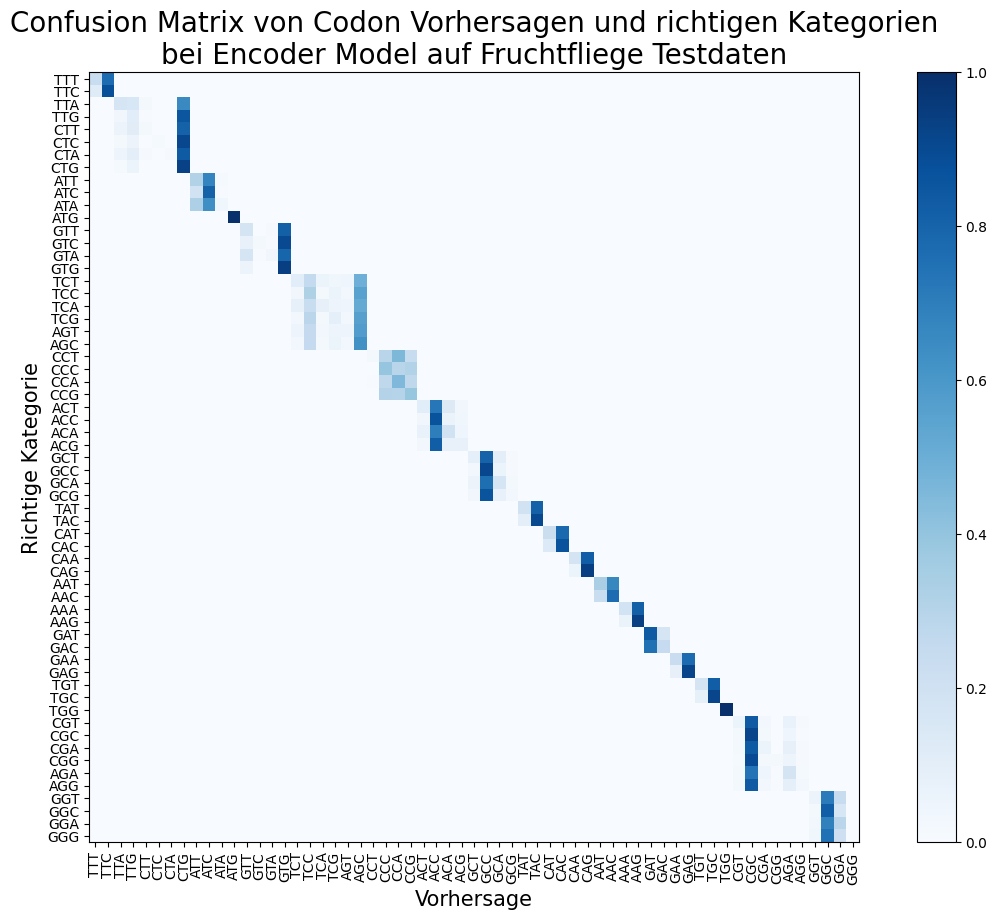

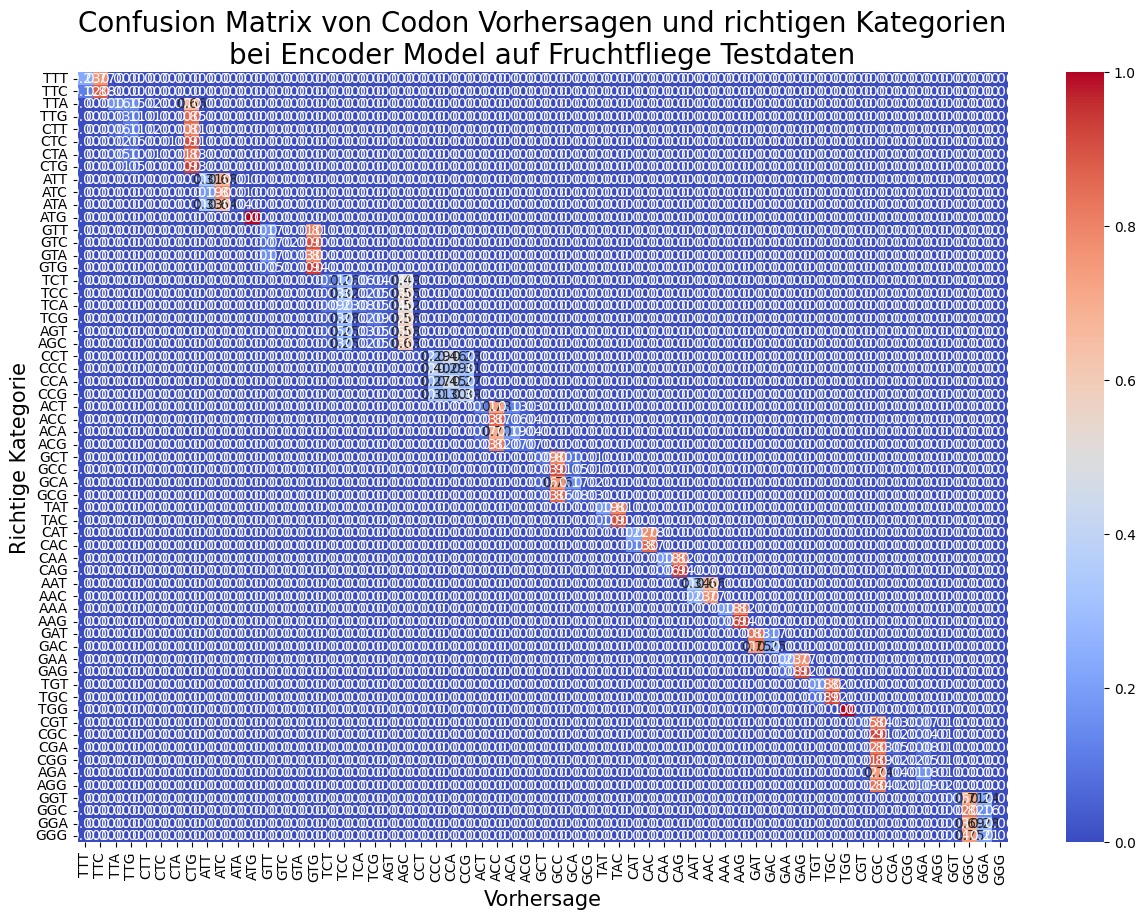

In [59]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien\nbei Encoder Model auf Fruchtfliege Testdaten'

plt = ml_evaluation.plot_confusion_matrix(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()
plt = ml_evaluation.plot_confusion_matrix_sns(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()

In [57]:
predicted_aa =  ml_evaluation.translate_codons(predicted)
labels_aa =  ml_evaluation.translate_codons(labels)

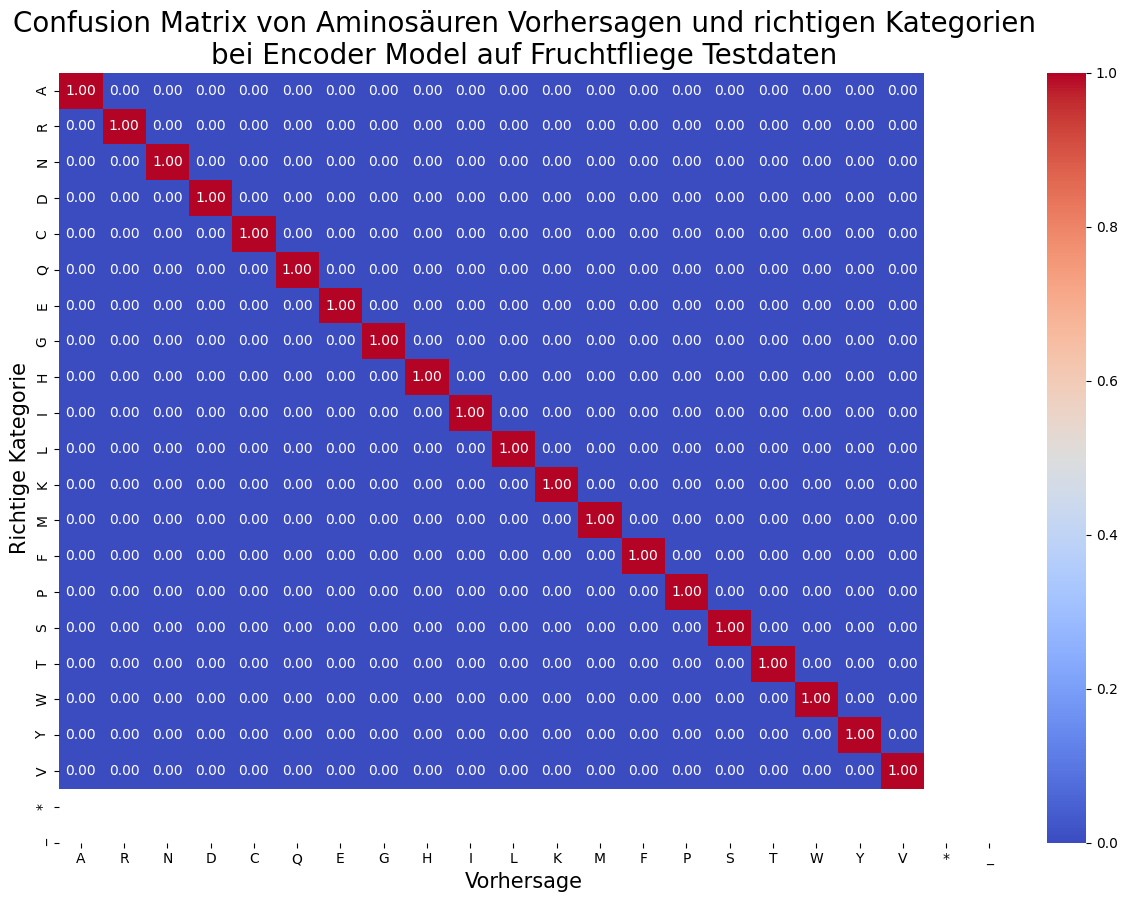

In [60]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, ml_helper.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien\nbei Encoder Model auf Fruchtfliege Testdaten')
plt.show()

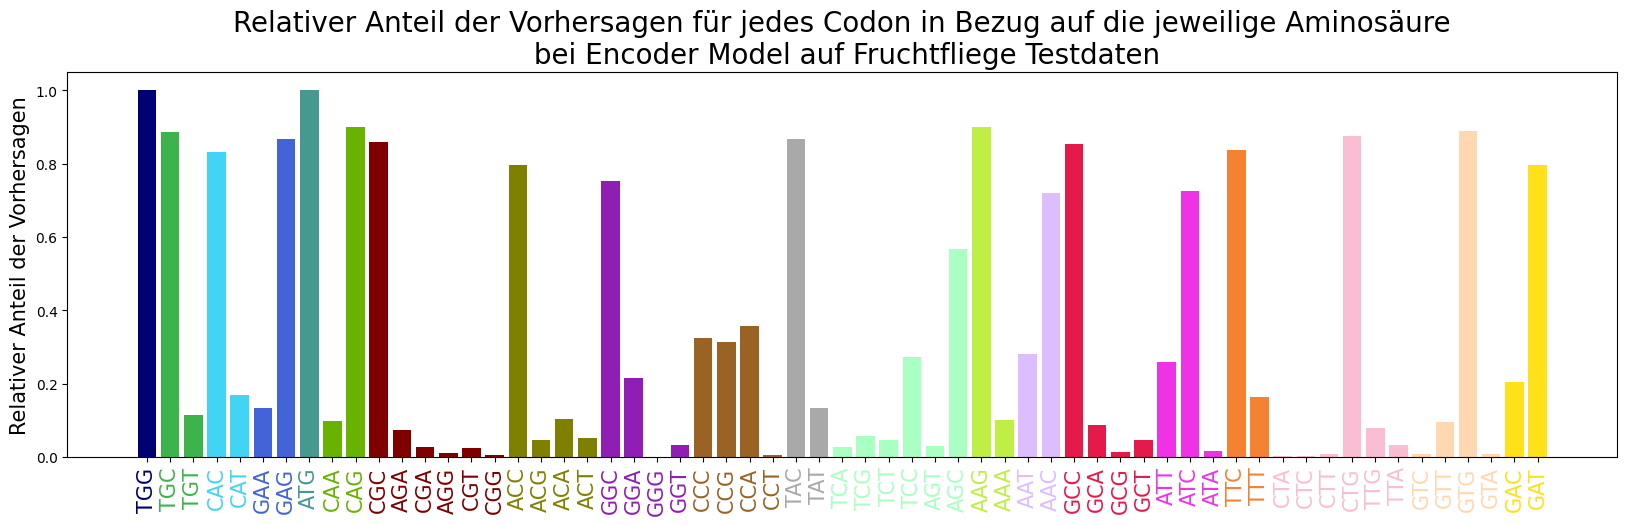

In [61]:
codon_counted_predicted = ml_evaluation.codon_count(predicted_int, labels)

plt = ml_evaluation.plot_relative_codon_count(codon_counted_predicted, predicted_int, 'Relativer Anteil der Vorhersagen für jedes Codon in Bezug auf die jeweilige Aminosäure\n bei Encoder Model auf Fruchtfliege Testdaten')

{'ATG': 33487, 'GAA': 7303, 'CGC': 23301, 'CAA': 4361, 'GCC': 42617, 'CTA': 115, 'GAC': 8527, 'TCA': 1004, 'TCG': 2173, 'TCT': 1143, 'CTC': 247, 'TAC': 23071, 'GTC': 454, 'TCC': 9092, 'AAT': 10937, 'CCC': 10771, 'CAG': 49727, 'CCG': 9605, 'CAC': 19641, 'ACC': 26730, 'GGC': 31132, 'CTT': 290, 'ACG': 1580, 'TTC': 26864, 'TAT': 3041, 'GCA': 3172, 'ACA': 3277, 'ACT': 1580, 'CCA': 10031, 'AGT': 819, 'CTG': 49327, 'AGA': 1408, 'ATT': 7565, 'GTT': 2876, 'CGA': 657, 'TGC': 18839, 'GGA': 7558, 'ATC': 25375, 'GTG': 36659, 'ATA': 540, 'GCG': 610, 'AAG': 50256, 'AAA': 4434, 'GTA': 328, 'GAG': 55368, 'GGG': 21, 'GAT': 33997, 'AGG': 222, 'CAT': 3426, 'AGC': 18974, 'TTG': 2417, 'AAC': 29115, 'TGG': 13922, 'CGT': 691, 'GCT': 1807, 'TGT': 1746, 'TTA': 1173, 'CGG': 184, 'GGT': 1111, 'TTT': 4412, 'CCT': 219}


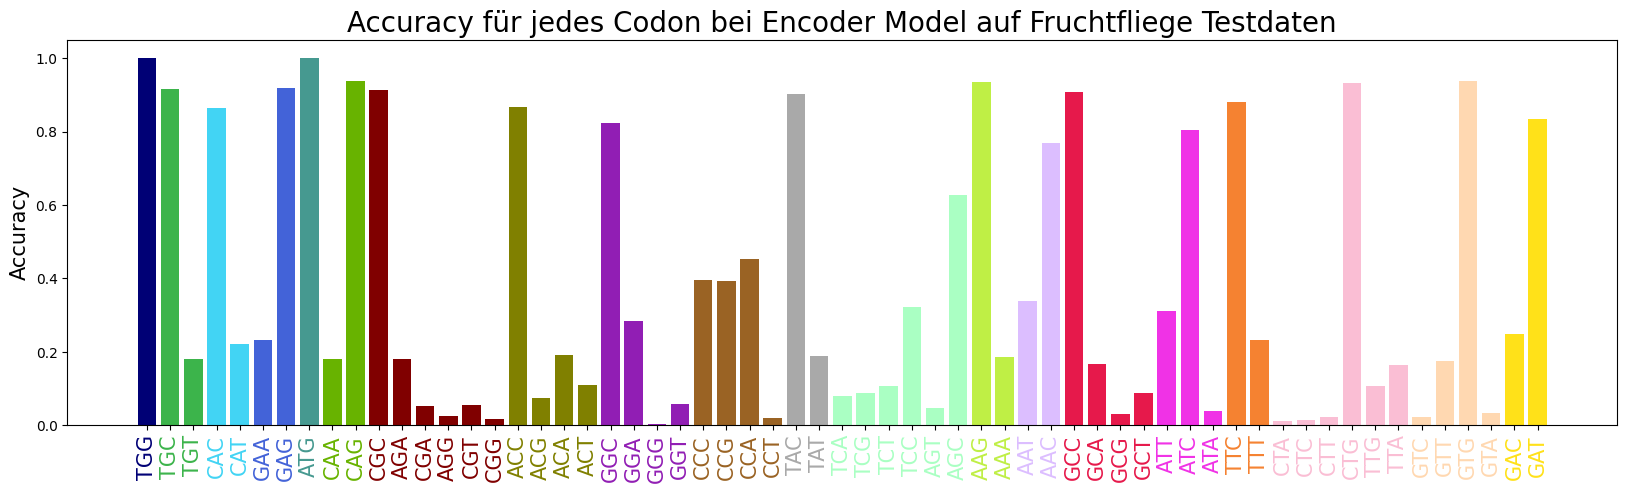

In [62]:
plt = ml_evaluation.plot_codon_acc(labels_int, predicted_int, 'Accuracy für jedes Codon bei Encoder Model auf Fruchtfliege Testdaten')

In [63]:
usage_biases_codons = {}
codon_to_aa = ml_evaluation.dict_aa_codon()
for codon in labels:
    aa = codon_to_aa[codon]
    usage_biases_codons[codon] = usage_biases[aa][codon]

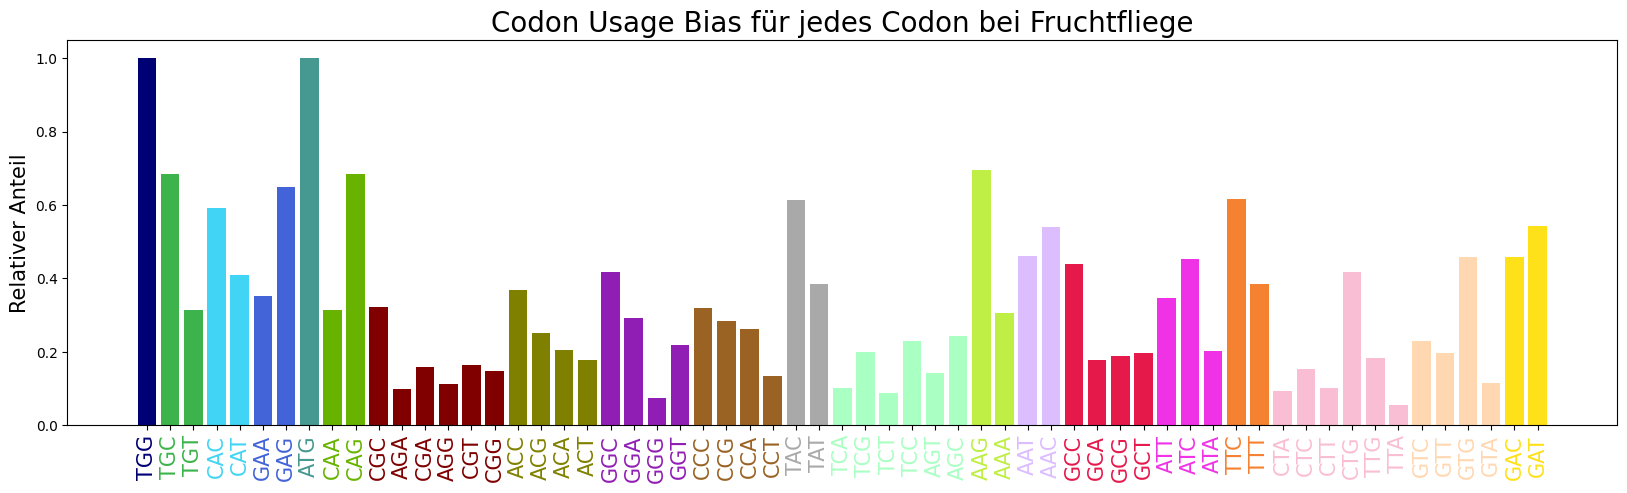

In [64]:
_, _ = ml_evaluation.plot_cub(usage_biases_codons, "Codon Usage Bias für jedes Codon bei Fruchtfliege")

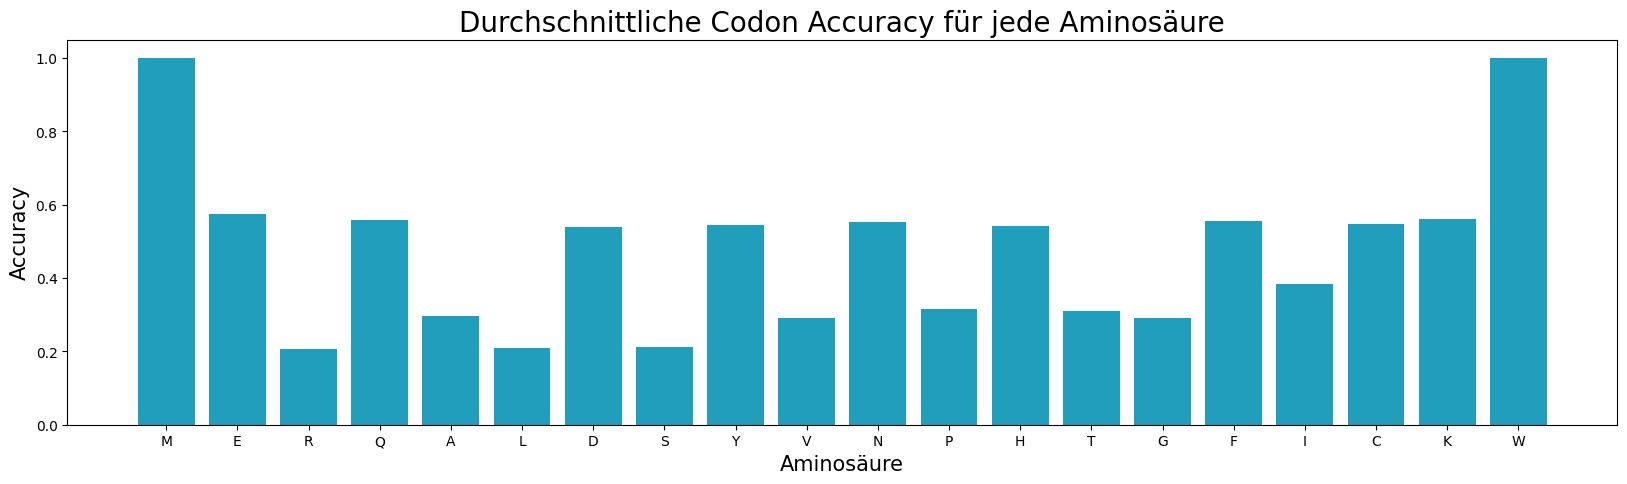

In [65]:
ml_evaluation.plot_avg_aa_acc(labels_int, predicted_int).show()

#### Comparison Max CUB

In [66]:
pn_dict = ml_evaluation.create_pn_dict(predicted, labels, organism)

In [67]:
cub_test_data = {}

for codon in pn_dict:
    aa = ml_helper.codon_to_amino_acid[codon]
    aa_codons = ml_helper.amino_acids_to_codons.get(aa, [])
    aa_sum = sum(pn_dict[c]['num'] for c in aa_codons)
    cub_test_data[codon] = pn_dict[codon]['num'] / aa_sum

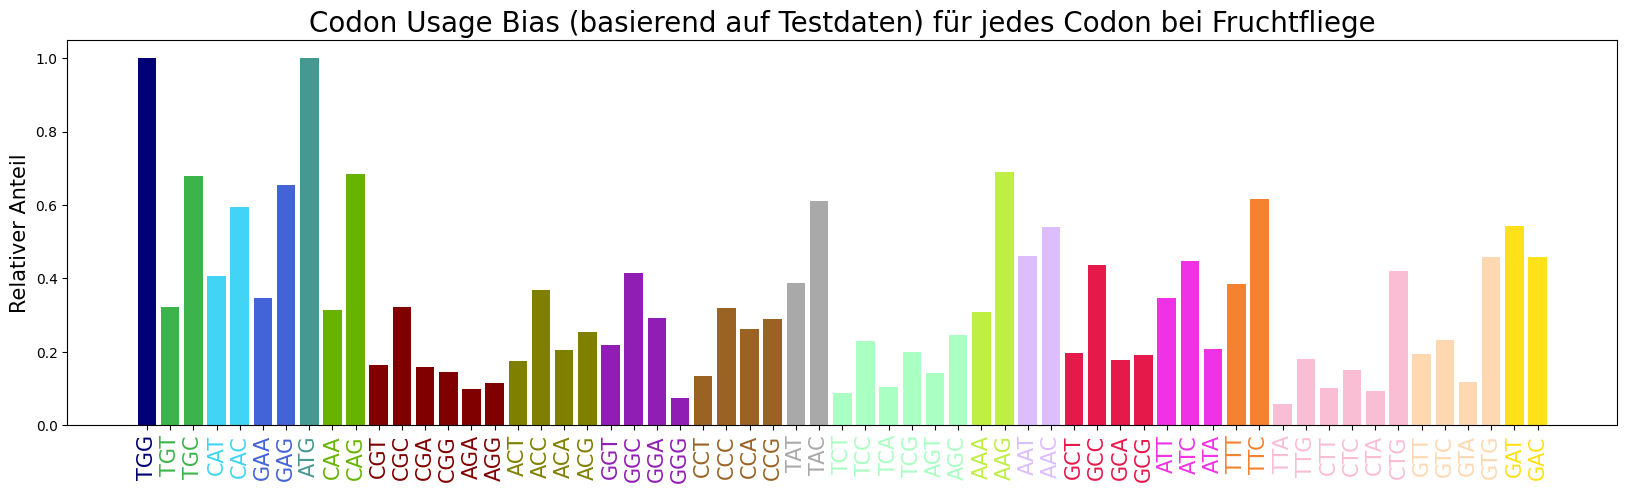

In [71]:
_, keys = ml_evaluation.plot_cub(cub_test_data, "Codon Usage Bias (basierend auf Testdaten) für jedes Codon bei Fruchtfliege")

In [69]:
pn_dict = { codon : pn_dict[codon] for codon in keys if codon in pn_dict}

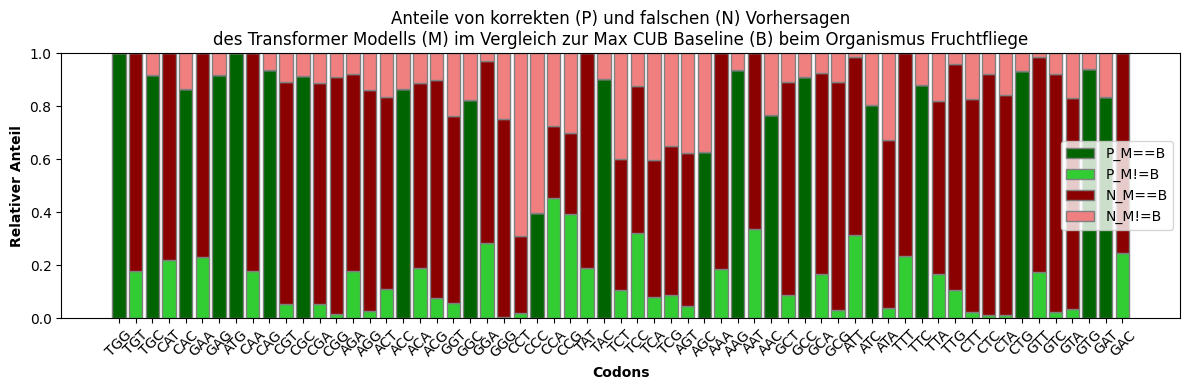

In [70]:
ml_evaluation.plot_pn_dict(pn_dict, 'Transformer', 'Fruchtfliege')

## Homo Sapiens

In [73]:
organism = "Homo.Sapiens"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

9139

In [74]:
EMBED_DIM = 64
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 4
DROPOUT = 0.2
POS_ENC = True

model = EncoderClassifier(
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
).to(device)
model = ml_helper.load_model( f'encoder_{EMBED_DIM}em_{NUM_ENCODER_LAYERS}l_{NUM_HEADS}h{"_posenc" if POS_ENC else ""}_{str(DROPOUT).replace(".","")}dr', organism, device=device)

encoder_classifier = Encoder_Classifier(model)
amino_seq = df['translation']
true_codons = df['codons']
pred_codons_replaced = encoder_classifier.predict_codons(amino_seq, replace=True)

accuracy = round(encoder_classifier.calc_accuracy(true_codons, pred_codons_replaced), 4)
print(f"Accuracy: {accuracy}")

Model loaded: 20240603201950_encoder_64em_4l_4h_posenc_02dr_80ep.pt
Model used max bias codon for 46.12% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5232


In [75]:
# Remove Padding
predictions = []
for codon_seq in pred_codons_replaced:
    predictions.append([codon for codon in codon_seq if codon != ''])

In [76]:
predicted, labels = ml_evaluation.flatten_for_plotting(predictions, true_codons, filter_pads=False)

In [77]:
# Translate to integers
predicted_int = []
for codon in predicted:
    predicted_int.append(ml_helper.codons_to_integer[codon])

labels_int = []
for codon in labels:
    labels_int.append(ml_helper.codons_to_integer[codon])

In [78]:
# Calculate Accuracy again to see if something changed
predicted_int_np = np.array(predicted_int)
labels_int_np = np.array(labels_int)
accuracy = np.sum(predicted_int_np == labels_int_np) / labels_int_np.size
accuracy

0.5231867034546321

In [79]:
ml_evaluation.get_unique_pred_classes(predicted, labels)

predicted different classes:  61 out of: 61


({'AAA',
  'AAC',
  'AAG',
  'AAT',
  'ACA',
  'ACC',
  'ACG',
  'ACT',
  'AGA',
  'AGC',
  'AGG',
  'AGT',
  'ATA',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCC',
  'CCG',
  'CCT',
  'CGA',
  'CGC',
  'CGG',
  'CGT',
  'CTA',
  'CTC',
  'CTG',
  'CTT',
  'GAA',
  'GAC',
  'GAG',
  'GAT',
  'GCA',
  'GCC',
  'GCG',
  'GCT',
  'GGA',
  'GGC',
  'GGG',
  'GGT',
  'GTA',
  'GTC',
  'GTG',
  'GTT',
  'TAC',
  'TAT',
  'TCA',
  'TCC',
  'TCG',
  'TCT',
  'TGC',
  'TGG',
  'TGT',
  'TTA',
  'TTC',
  'TTG',
  'TTT'},
 {'AAA',
  'AAC',
  'AAG',
  'AAT',
  'ACA',
  'ACC',
  'ACG',
  'ACT',
  'AGA',
  'AGC',
  'AGG',
  'AGT',
  'ATA',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCC',
  'CCG',
  'CCT',
  'CGA',
  'CGC',
  'CGG',
  'CGT',
  'CTA',
  'CTC',
  'CTG',
  'CTT',
  'GAA',
  'GAC',
  'GAG',
  'GAT',
  'GCA',
  'GCC',
  'GCG',
  'GCT',
  'GGA',
  'GGC',
  'GGG',
  'GGT',
  'GTA',
  'GTC',
  'GTG',
  'GTT',
  'TAC',
  'TAT',


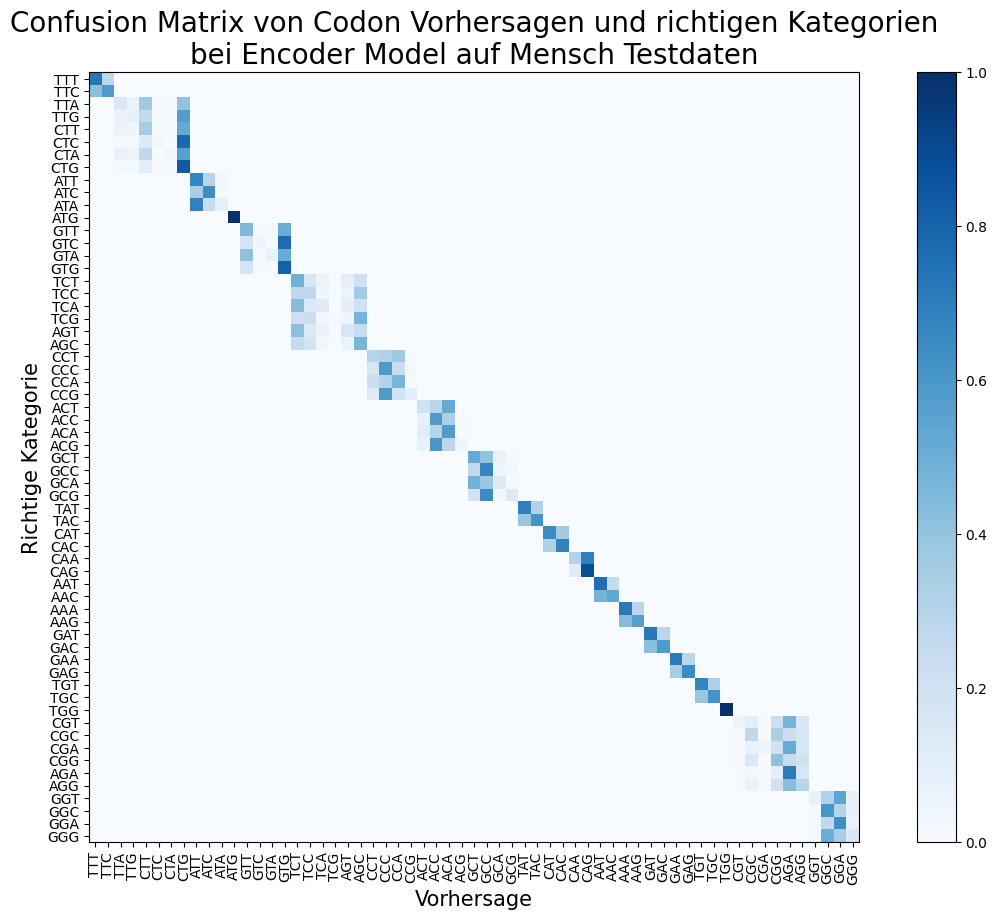

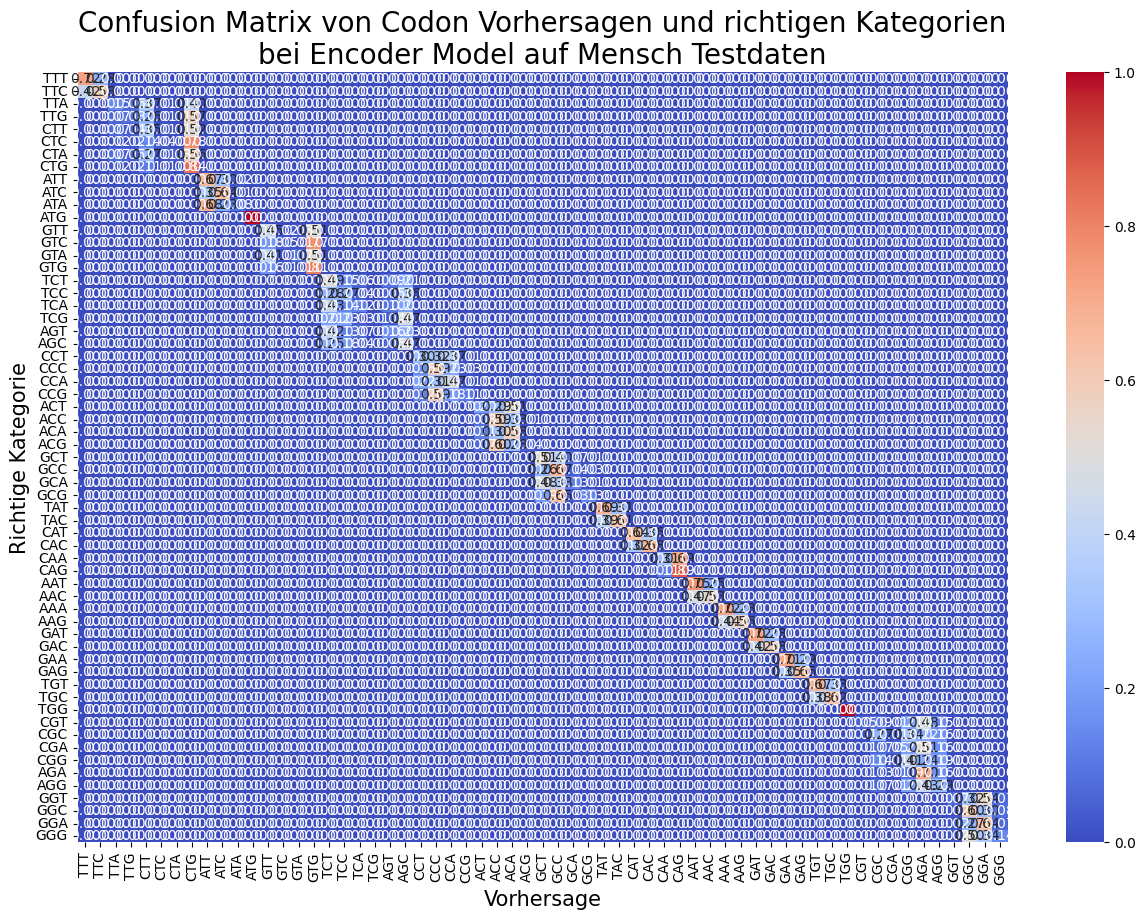

In [86]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien\nbei Encoder Model auf Mensch Testdaten'

plt = ml_evaluation.plot_confusion_matrix(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()
plt = ml_evaluation.plot_confusion_matrix_sns(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()

In [80]:
predicted_aa =  ml_evaluation.translate_codons(predicted)
labels_aa =  ml_evaluation.translate_codons(labels)

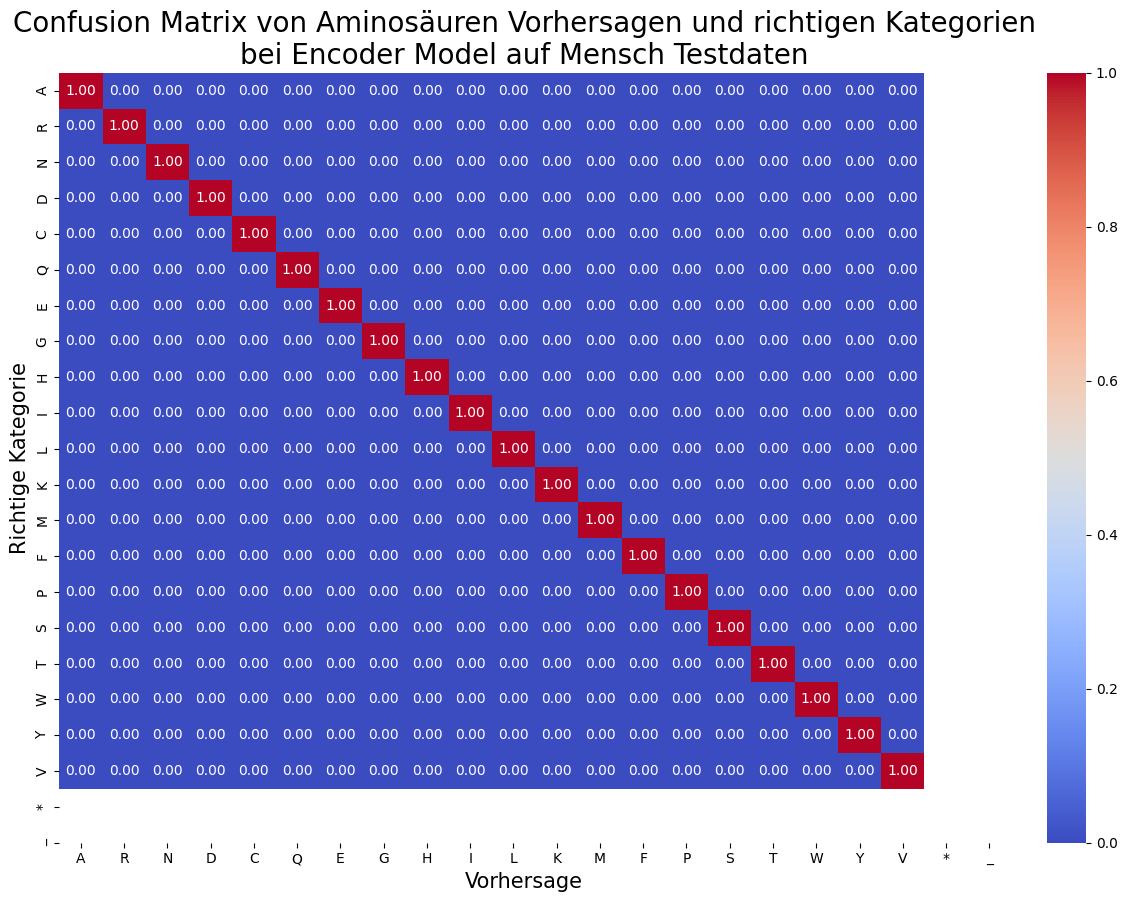

In [87]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, ml_helper.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien\nbei Encoder Model auf Mensch Testdaten')
plt.show()

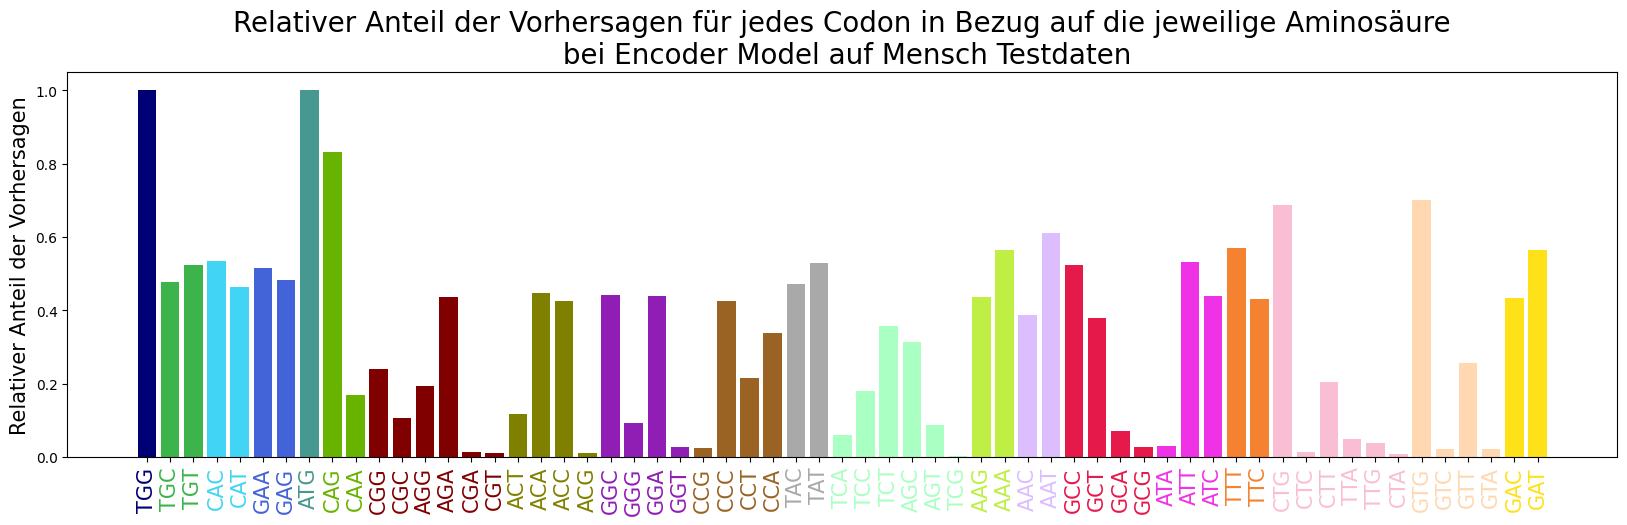

In [88]:
codon_counted_predicted = ml_evaluation.codon_count(predicted_int, labels)

plt = ml_evaluation.plot_relative_codon_count(codon_counted_predicted, predicted_int, 'Relativer Anteil der Vorhersagen für jedes Codon in Bezug auf die jeweilige Aminosäure\n bei Encoder Model auf Mensch Testdaten')

{'ATG': 137692, 'GAA': 155434, 'CGG': 29574, 'CAC': 63117, 'CAG': 205822, 'CCG': 4460, 'CTG': 199304, 'GCC': 113961, 'CAA': 27525, 'GGC': 78501, 'TCA': 11436, 'GCT': 62525, 'GGG': 14292, 'ACT': 17995, 'CCC': 73963, 'TAC': 52797, 'CCT': 37296, 'TCC': 30603, 'TCT': 53502, 'CTC': 4117, 'CGC': 15661, 'TGC': 42592, 'AGC': 60770, 'AAG': 118001, 'AGG': 22973, 'AGT': 14601, 'GAG': 169201, 'TTT': 78423, 'GAC': 93057, 'AAA': 125652, 'ATA': 4183, 'AGA': 60151, 'ATT': 70553, 'CCA': 57366, 'CTT': 31510, 'AAC': 62447, 'GCA': 14154, 'GAT': 111811, 'TTA': 8258, 'AAT': 88253, 'TTG': 7354, 'TTC': 64749, 'ATC': 77611, 'GTG': 137702, 'ACA': 62026, 'GGA': 69789, 'CGA': 1997, 'CAT': 47538, 'GTC': 4085, 'ACC': 67895, 'TGG': 74383, 'GTT': 33878, 'GTA': 3548, 'TGT': 43561, 'CTA': 1592, 'ACG': 1643, 'TAT': 52717, 'GCG': 5465, 'GGT': 4805, 'CGT': 1510, 'TCG': 413}


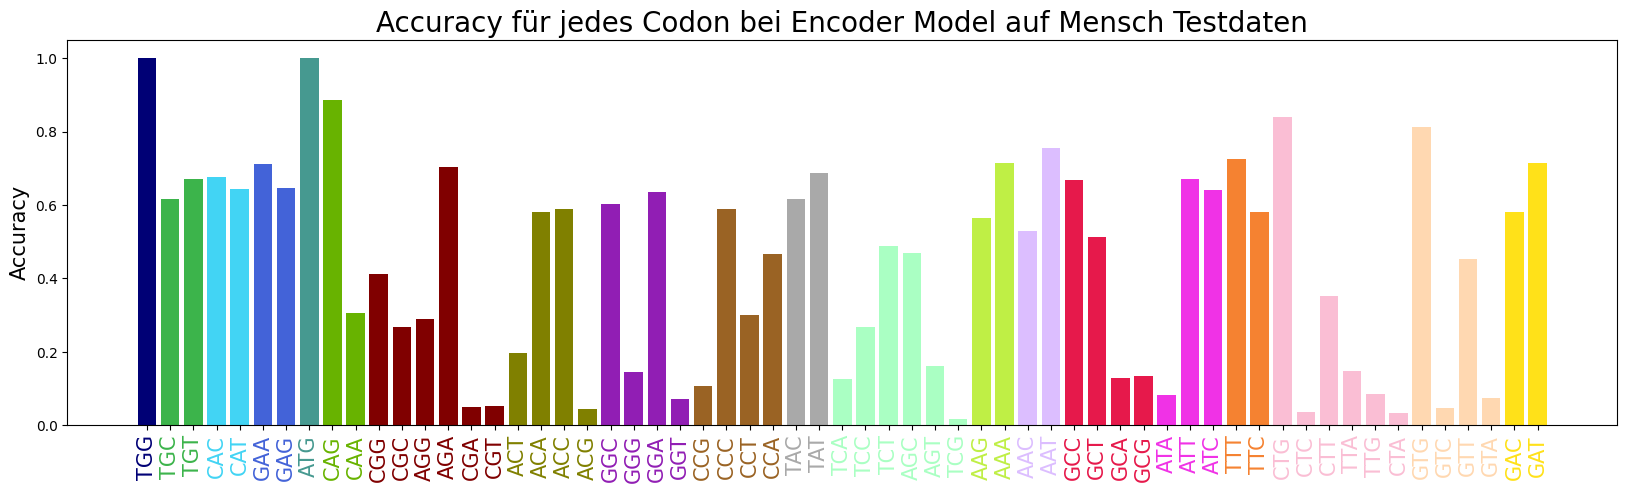

In [89]:
plt = ml_evaluation.plot_codon_acc(labels_int, predicted_int, 'Accuracy für jedes Codon bei Encoder Model auf Mensch Testdaten')

In [90]:
usage_biases_codons = {}
codon_to_aa = ml_evaluation.dict_aa_codon()
for codon in labels:
    aa = codon_to_aa[codon]
    usage_biases_codons[codon] = usage_biases[aa][codon]

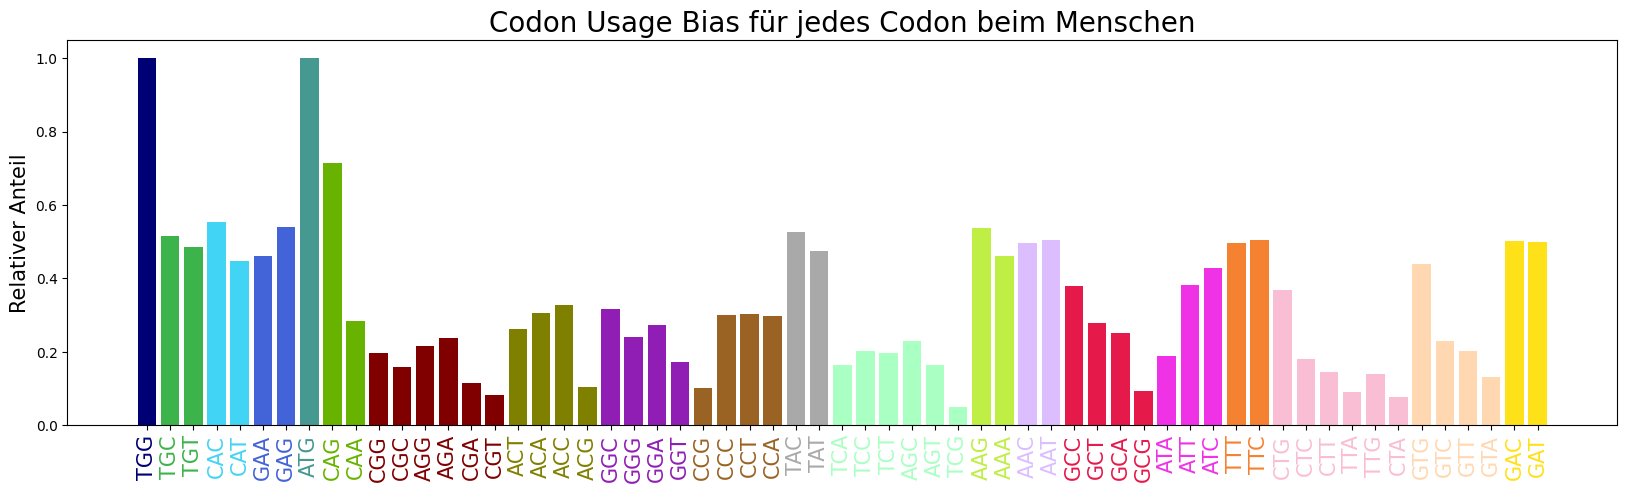

In [91]:
plt = ml_evaluation.plot_cub(usage_biases_codons, "Codon Usage Bias für jedes Codon beim Menschen")

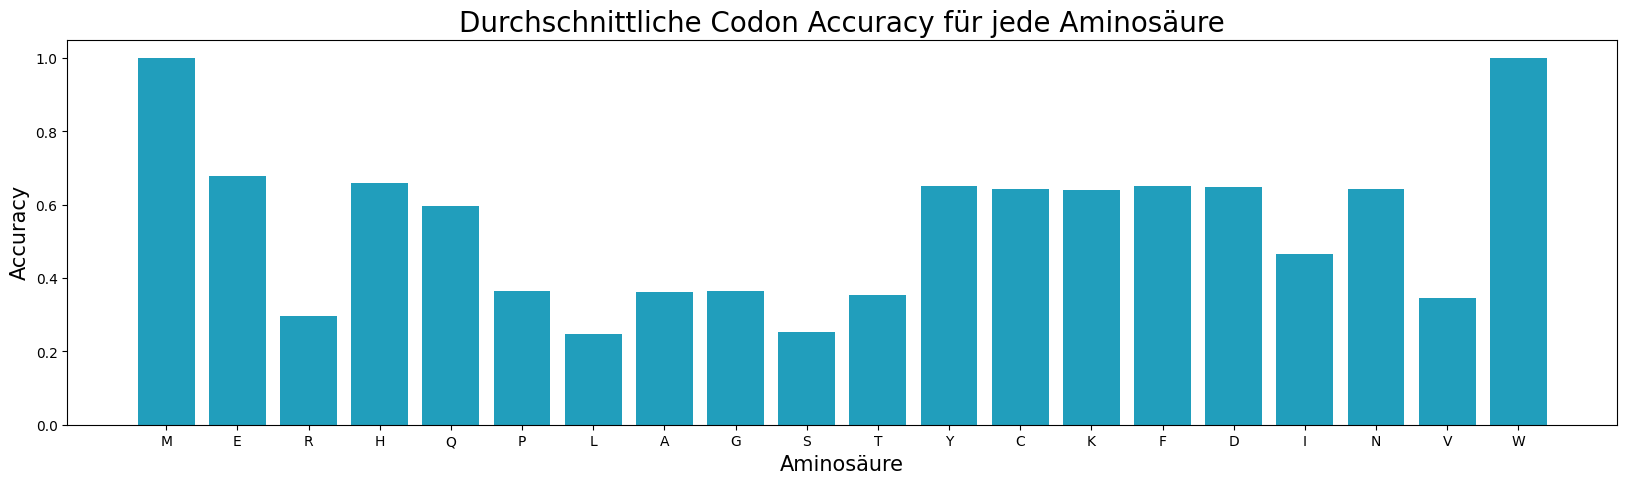

In [92]:
ml_evaluation.plot_avg_aa_acc(labels_int, predicted_int).show()

#### Comparison Max CUB

In [81]:
pn_dict = ml_evaluation.create_pn_dict(predicted, labels, organism)

In [82]:
cub_test_data = {}

for codon in pn_dict:
    aa = ml_helper.codon_to_amino_acid[codon]
    aa_codons = ml_helper.amino_acids_to_codons.get(aa, [])
    aa_sum = sum(pn_dict[c]['num'] for c in aa_codons)
    cub_test_data[codon] = pn_dict[codon]['num'] / aa_sum

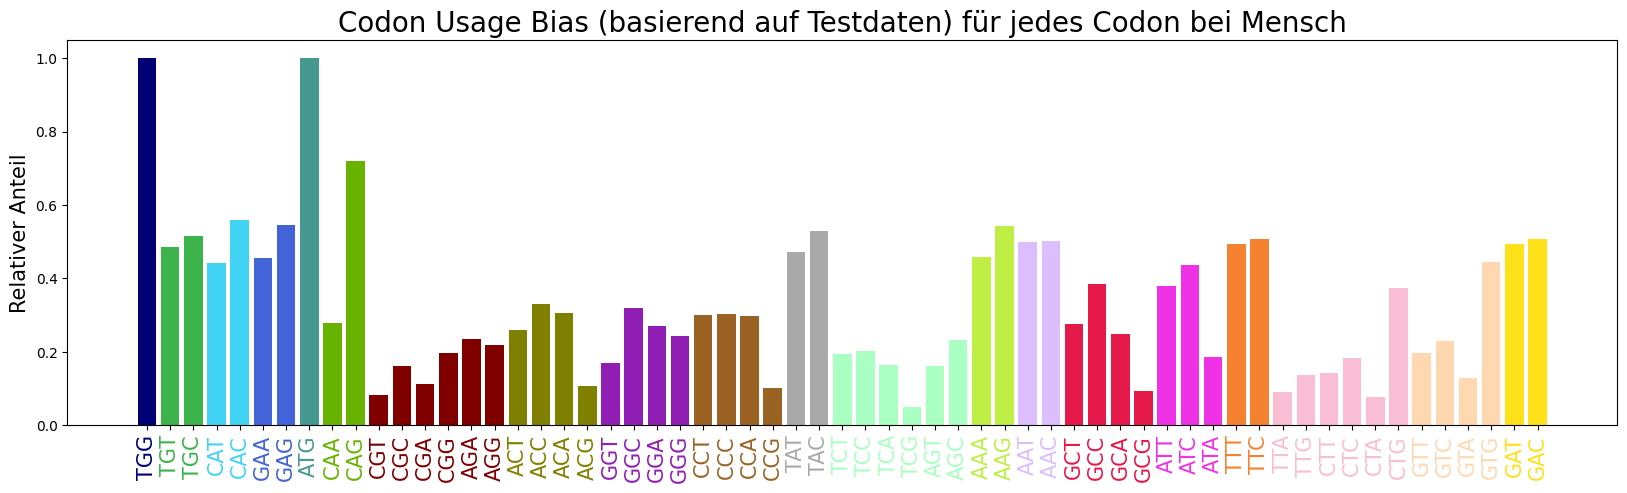

In [83]:
_, keys = ml_evaluation.plot_cub(cub_test_data, "Codon Usage Bias (basierend auf Testdaten) für jedes Codon bei Mensch")

In [84]:
pn_dict = { codon : pn_dict[codon] for codon in keys if codon in pn_dict}

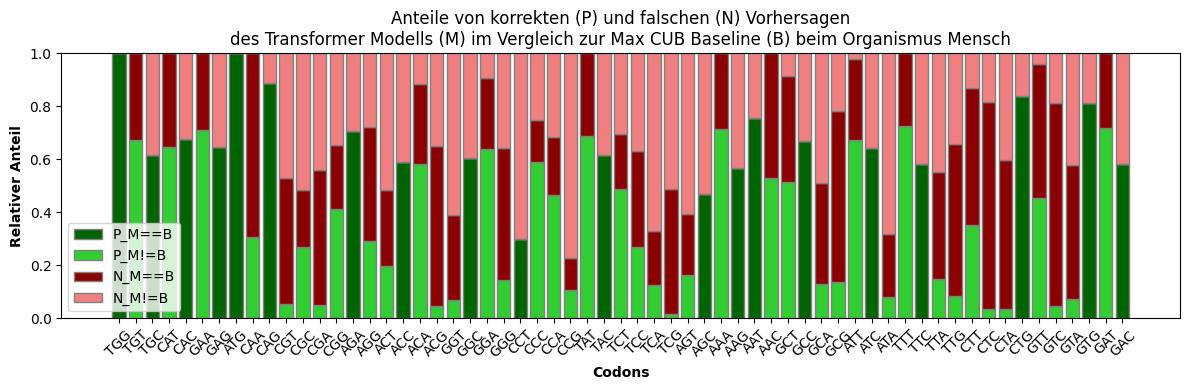

In [85]:
ml_evaluation.plot_pn_dict(pn_dict, 'Transformer', 'Mensch')